In [1]:
%matplotlib inline

from analyze_csv import *
from mutations import get_all_moves
from evaluation_indices import *
from batch_tasks import *
from data_generation import *
from individual import Individual
import numpy as np
import pandas as pd
import os
import traceback
import pickle
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy.stats import entropy, skew, kurtosis
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import f1_micro
from time import time
from random import shuffle
from matplotlib import pyplot as plt

/nix/store/x79dhsd48rgzgm12ywrap31jaj0nwgvy-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [17]:
all_moves = np.array(get_all_moves())
all_moves

array(['unguided_merge_gene_move', 'unguided_remove_and_reclassify_move',
       'unguided_split_gene_move', 'expand_cluster_move',
       'split_farthest_move', 'unguided_eliminate_move',
       'knn_reclassification_move', 'one_nth_change_move',
       'centroid_k_means_move', 'centroid_hill_climbing_move',
       'prototype_k_means_move', 'prototype_hill_climbing_move',
       'tree_hill_climbing_move',
       'guided_remove_and_reclassify_move("density_based_validity_separation")',
       'guided_remove_and_reclassify_move("density_based_sparseness_separation")',
       'guided_remove_and_reclassify_move("mean_centroid_distance_separation")',
       'guided_remove_and_reclassify_move("diameter_separation")',
       'guided_histogram_split_gene_move("density_based_validity_separation")',
       'guided_histogram_split_gene_move("density_based_sparseness_separation")',
       'guided_histogram_split_gene_move("mean_centroid_distance_separation")',
       'guided_histogram_split_gene_

In [18]:
len(all_moves)

31

In [3]:
index_minimized = {}
for name, func in indices:
    index_minimized[name] = eval(func).is_minimized
index_minimized

{'silhouette': False,
 'calinski_harabaz': False,
 'davies_bouldin': True,
 'dvcb': False,
 'dunn': False,
 'generalized_dunn_41': False,
 'generalized_dunn_43': False,
 'generalized_dunn_51': False,
 'generalized_dunn_53': False,
 'generalized_dunn_13': False}

In [4]:
if False:
    mutation_usage = {}
    def parse_folder(path):
        for idx, filename in enumerate(os.listdir(path)):
            index_name = filename[:filename.find('-')]
            try:
                data, time = read_results(path + '/' + filename)
            except:
                traceback.print_exc()
                continue
            n_clusters = data.iloc[-1]['n_clusters']
            unique_numbers = np.unique(np.bincount(data.index[1:]))
            mutation_names = np.array([s[:s.find(':')] if s is not None and s != 'None' else s for s in data['detail']])
            mut_indices = np.argwhere(mutation_names[:, None] == all_moves[None, :])[:, 1]
            assert len(mut_indices) == len(data) - 1
            data['mutation_index'] = np.hstack([[-1], mut_indices])
            index_series = [data[data['mutation_index'] == i]['index'].rename(all_moves[i] + '_index') for i in range(len(all_moves))]            
            assert all(b == a + '_index' for a, b in zip(all_moves, (s.name for s in index_series)))
            table = pd.concat(index_series, axis=1).values
            if not index_minimized[index_name]:
                max_indices = np.nanargmax(table, axis=1)
                max_values = np.nanmax(table, axis=1)
                change_steps = np.argwhere(max_values[1:] > max_values[:-1]).flatten() + 1
            else:
                max_indices = np.nanargmin(table, axis=1)
                max_values = np.nanmin(table, axis=1)
                change_steps = np.argwhere(max_values[1:] < max_values[:-1]).flatten() + 1
            c_usage = np.unique(max_indices[change_steps])
            diff = 0 if filename not in mutation_usage else len(np.setdiff1d(c_usage, mutation_usage[filename])) + len(np.setdiff1d(mutation_usage[filename], c_usage))
            mutation_usage[filename] = c_usage if filename not in mutation_usage else np.unique(np.hstack([c_usage, mutation_usage[filename]]))
            print(idx, filename, n_clusters, len(unique_numbers), len(c_usage), len(change_steps), diff)
            
    parse_folder('/tmp/results-1010')
    parse_folder('/tmp/results2')
    mutation_usage = list(mutation_usage.items())
    with open('mutation_usage.dat', 'wb') as f:
        pickle.dump(mutation_usage, f)
else:
    with open('mutation_usage.dat', 'rb') as f:
        mutation_usage = pickle.load(f)

In [9]:
list(zip(all_moves, np.bincount(np.hstack([a[1] for  a in mutation_usage]))))

[('unguided_merge_gene_move', 436),
 ('unguided_remove_and_reclassify_move', 509),
 ('unguided_split_gene_move', 248),
 ('expand_cluster_move', 418),
 ('split_farthest_move', 234),
 ('unguided_eliminate_move', 450),
 ('knn_reclassification_move', 264),
 ('one_nth_change_move', 334),
 ('centroid_k_means_move', 447),
 ('centroid_hill_climbing_move', 154),
 ('prototype_k_means_move', 281),
 ('prototype_hill_climbing_move', 35),
 ('tree_hill_climbing_move', 329),
 ('guided_remove_and_reclassify_move("density_based_validity_separation")',
  473),
 ('guided_remove_and_reclassify_move("density_based_sparseness_separation")',
  420),
 ('guided_remove_and_reclassify_move("mean_centroid_distance_separation")',
  350),
 ('guided_remove_and_reclassify_move("diameter_separation")', 420),
 ('guided_histogram_split_gene_move("density_based_validity_separation")',
  196),
 ('guided_histogram_split_gene_move("density_based_sparseness_separation")',
  171),
 ('guided_histogram_split_gene_move("mean_cent

In [19]:
generated_prefix = 'scratch'
real_prefix = 'datasets'
tasks_list = init_batch(real_prefix)
datasDict = {a: {'dataname': a, 'dataset': eval(b)} for a, b in datas}
datasDict.keys()

Excluding column number 2 because it is a single value
Excluding column number 23 because it is a single value


dict_keys(['generated_2dim_10cl', 'generated_2dim_30cl', 'generated_10dim_10cl', 'generated_10dim_30cl', 'immunotherapy', 'user_knowledge', 'sales_transactions', 'Concrete_Data', 'HappinessRank_2015', 'ICU', 'ParkinsonSpeechDataset', 'analcatdata_lawsuit', 'analcatdata_vineyard', 'analcatdata_wildcat', 'arsenic_female_bladder', 'arsenic_male_bladder', 'arsenic_male_lung', 'autoUniv_au7_1100', 'autoUniv_au7_500', 'autoUniv_au7_700', 'badges2', 'banknote_authentication', 'boston_corrected', 'breast_tissue', 'chscase_census2', 'chscase_census6', 'collins', 'dataset_185_yeast', 'dataset_187_abalone', 'dataset_18_mfeat_morphological', 'dataset_2181_auto_price', 'dataset_36_segment', 'dataset_39_ecoli', 'dataset_41_glass', 'dataset_43_haberman', 'dataset_53_heart_statlog', 'dataset_54_vehicle', 'dataset_8_liver_disorders', 'debutanizer', 'disclosure_x_bias', 'fri_c0_1000_25', 'fri_c0_100_25', 'fri_c0_250_10', 'fri_c1_1000_5', 'fri_c1_100_10', 'fri_c1_100_5', 'fri_c1_250_10', 'fri_c1_250_5', 

In [20]:
for k, v in datasDict.items():
    dataset = v['dataset']
    v['ma1'] = np.log2(len(dataset))
    v['ma2'] = np.log2(dataset.shape[1])
    meta_attrs = []
    meta_entropy = []
    cont_attrs = []
    for i, s in enumerate(dataset.T):
        uniq = np.unique(s)
        uniq.sort()
        if len(uniq) < len(s) * 0.3:
            meta_attrs.append(i)
            ints = np.searchsorted(uniq, s)
            meta_entropy.append(entropy(ints))
        else:
            cont_attrs.append(i)
    v['ma3'] = len(meta_attrs)
    v['ma5'] = sum(meta_entropy) / len(meta_entropy) if len(meta_entropy) > 0 else 0
    # TODO ma6
    if len(cont_attrs) > 0:
        corr = np.abs(np.corrcoef(dataset[:, cont_attrs], rowvar=False))
        v['ma7'] = corr[np.arange(0, len(corr))[None, :] <= np.arange(0, len(corr))[:, None]].mean() if isinstance(corr, np.ndarray) else corr
        v['ma8'] = np.mean(skew(dataset[:, cont_attrs]))
        v['ma9'] = np.mean(kurtosis(dataset[:, cont_attrs]))
    else:
        v['ma7'], v['ma8'], v['ma9'] = 0, 0, 0
    dists = pdist(dataset)
    v['md1'] = dists.mean()
    v['md2'] = dists.var()
    v['md3'] = dists.std()
    v['md4'] = skew(dists)
    v['md5'] = kurtosis(dists)
    hist = np.histogram(dists, bins=9, range=(0, dists.max()))[0]
    assert len(hist) == 9
    for i, h in enumerate(hist):
        v['md' + str(i + 6)] = h
    z = np.abs(((dists - v['md1']) / v['md3']))
    v['md16'] = (z < 1).sum()
    v['md17'] = ((1 <= z) & (z < 2)).sum()
    v['md18'] = ((2 <= z) & (z < 3)).sum()
    v['md19'] = (3 <= z).sum()

In [21]:
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering, MeanShift
state_of_the_art = ['KMeans(n_clusters=n_clusters)', 'AffinityPropagation()', 'AgglomerativeClustering(n_clusters=n_clusters)', 'MeanShift()']

In [22]:
for k, v in datasDict.items():
    start = time()
    dataset = v['dataset']
    n_clusters = int(np.cbrt(len(dataset)))
    values = []
    fnum = 1
    for algo in state_of_the_art:
        try:
            cls = eval(algo).fit_predict(dataset)
        except:
            traceback.print_exc()
            cls = None
        indiv = Individual({'data': dataset, 'labels': cls})
        for _, idxstr in indices:
            try:
                idx = eval(idxstr)(indiv)
            except:
                if cls is not None:
                    traceback.print_exc()
                idx = np.nan
            v['ml' + str(fnum)] = idx
            values.append(idx)
            fnum += 1
    print(k, 'took', time() - start, 'seconds,', values)

/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


generated_2dim_10cl took 15.756421566009521 seconds, [nan, 20689.835549467487, 3.513413420143542, 0.04383234864563659, 0.037868448519518635, 0.5359873194599644, 0.12212828007784197, 4.113810919510055, 0.9373592134071678, 0.008628578175253945, -0.4792510995092671, 8.588687083807738, 14.709404485758322, -0.353384979420912, 0.0005227863271917354, 0.001173604068020754, 7.083524863059628e-05, 0.0017604061020311309, 0.00010625287294589443, 3.1553826777164825e-05, 0.7080526112138442, 20532.027486792307, 3.5235245084209232, 0.04490259890482793, 0.08152223388414177, 0.5133660881799031, 0.1169738818874883, 4.523546782766988, 1.0307202584337505, 0.018575383877374514, 0.3814387801551384, 4258.397449231275, 9.372024621639703, 0.273267171822439, 0.5122049534716551, 1.3299988859013268, 0.09272459668541633, 34.57504419086646, 2.4104960251947087, 0.03570980264298902]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], ind

generated_2dim_30cl took 18.319862365722656 seconds, [0.6531285210080675, 2252.2723227073557, 5.109952215573632, 0.11745088069411688, 0.056676282684684026, 0.7220312012425686, 0.10949359163988173, 5.201531086265349, 0.7887946112045534, 0.008594766737592094, nan, 2.5898242643660145, 71.20646890012677, 0.3010999859973719, 0.0001522438640055314, 0.0025739161807757155, 0.0009623365286879213, 0.0038608742711635736, 0.0014435047930318819, 5.6920980059639927e-05, 0.6424070111975099, 2219.320042355842, 5.459408548171235, 0.15134879749062186, 0.19607973875088028, 0.6763873234364891, 0.11773683768501302, 7.448785157122927, 1.2965890675463905, 0.03413104825404056, nan, nan, 0.0, -0.5090521831735889, nan, nan, nan, nan, nan, nan]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


generated_10dim_10cl took 163.80695796012878 seconds, [0.896741731874847, 21643.098472191097, 0.7029130206365956, 0.41320235309290054, 3.5841902206942082, 4.096901293759184, 0.9571759404367534, 42.71687125128013, 9.980118748465786, 0.8373891385724096, -0.09166666666666666, 206.80664059019176, 0.25828795062981774, 0.5337959618772918, 0.11876675521651886, 0.11876675521651886, 0.035749575800771184, 0.17815013282477832, 0.05362436370115679, 0.035749575800771184, nan, 21643.098472191105, 0.7029130206365956, 0.41320235309290054, 3.5841902206942082, 4.096901293759184, 0.9571759404367534, 42.71687125128013, 9.980118748465786, 0.8373891385724096, 0.14287055763843723, 170.9278997275985, 20.22445956276663, -0.4480632811125098, 0.016722668676400494, 0.6292466832173836, 0.03185166874085012, 24.55843150122127, 1.2431166438131627, 0.0008464802713305492]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], ind

generated_10dim_30cl took 75.52769637107849 seconds, [nan, 270.3626296246689, 9.228659845839223, 0.006514522964208998, 0.3958921489118724, 0.5499208439352284, 0.07116942606577768, 4.320261059526627, 0.5591177411290371, 0.05123540475458674, nan, 46.40234213731991, 2.2358169242103423, 0.3158746739643479, 0.03093106308447785, 0.030931063084477847, 0.006143862275642846, 0.04639659462671677, 0.00921579341346427, 0.006143862275642847, nan, 272.37311145652404, 9.38083668610478, 0.04780212431791098, 0.5498510920419987, 0.6373499143163366, 0.07350851614537506, 6.699420903557321, 0.7726752268917402, 0.06341687190823138, nan, nan, 0.0, -0.5193213949104618, nan, nan, nan, nan, nan, nan]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


immunotherapy took 0.39121270179748535 seconds, [0.1899372092951887, 26.873085841036858, 4.589773778315502, -0.053475611068705436, 0.1649469698466324, 0.2481361554997881, 0.1326653407934593, 1.8843006515519929, 1.0074363713420877, 0.08818846219115631, -0.03834534280793953, 6.157033808890821, 8.950199407387203, -0.2788446919025108, 0.05179899188626315, 0.11343436695105029, 0.05163172091373991, 0.8392186408417425, 0.38198566990061367, 0.02357725585790695, 0.21988587967237533, 26.359628821975964, 4.574050531091449, -0.03307216462867775, 0.23275978580588663, 0.24828799741456084, 0.129910114154216, 1.8409825448768162, 0.9632453241851334, 0.1217853889814341, 0.3463406063647519, 18.284517971465583, 2.9755329534416526, -0.06636375786271508, 0.20333372557874918, 0.5685299481092794, 0.15967301254948246, 3.1631771050319, 0.8883859491794299, 0.0571067691755581]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

user_knowledge took 1.5851831436157227 seconds, [0.1696230096716171, 55.25837853886137, 6.22229261930748, -0.13270545009444748, 0.13809218615259441, 0.4438271705674369, 0.13072986641350273, 3.0850644829504543, 0.9087097286484721, 0.04067523181466468, 0.21200484762277852, 36.47276521640305, 3.1882811287815263, -0.09737465547693304, 0.12134272765412221, 0.27113659104062493, 0.14999016466822604, 1.2473974711681994, 0.6900483309507046, 0.06712563447183904, 0.15226812903782663, 53.19572471661538, 6.624189791795762, -0.1422761060583533, 0.19392237881430177, 0.4257799228226776, 0.11250473640976555, 3.639335564711141, 0.9616293922459809, 0.051240523432439566, nan, nan, 0.0, -0.5387596899224806, nan, nan, nan, nan, nan, nan]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


sales_transactions took 8.669520854949951 seconds, [-0.00995253205150641, 58.21949234825501, 9.85698439475055, -0.12033023907657023, 0.20851441405707477, 0.1481766039352161, 0.0781272439936826, 3.0046787520355767, 1.5842397770538084, 0.10994081434312826, -0.36676617437568876, 10.395758637814994, 35.29496906260115, -0.09989252380224893, 0.18057877962865382, 0.05428465184205218, 0.00945623924829753, 0.649653596179423, 0.11316789599874595, 0.03145633407215369, -0.06710459567336101, 54.54014127622592, 11.26576279013674, -0.12727407424062875, 0.20851441405707477, 0.12535354133480217, 0.0585680178158585, 2.718270818664964, 1.270037783062598, 0.09742266382998094, 0.022061020672370278, 8.061982293580858, 11.751879079407152, -0.13425079633956083, 0.1559430607378201, 0.21401612285738544, 0.01793515757823609, 0.7595364223738309, 0.06365130458307548, 0.013068470404115299]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


Concrete_Data took 9.425957679748535 seconds, [0.19257952336714046, 427.39887751857026, 8.244035749589987, -0.29406926698138075, 0.02952416453533877, 0.2934987412189025, 0.06632058736213797, 2.9840799096994566, 0.674299083958312, 0.006671442355180921, -0.12130870585571496, 31.527970485806183, 33.037840111932134, -0.5017940340201748, 0.0003308122873333616, 0.07977311167054461, 0.012317122768962583, 0.4480967103733849, 0.06918699895813617, 5.107805714529829e-05, 0.13210122707293975, 398.8534096500134, 9.2856402647622, -0.2990286660982001, 0.040118241904331824, 0.2545952719269549, 0.05499065762263179, 3.417943293996407, 0.7382499605399281, 0.008665237528904244, 0.451923873092608, 257.92276049771766, 11.597482048324473, -0.21076590960951067, 0.15966497058241555, 0.6526597819744816, 0.055148492454569494, 22.152677258049245, 1.871858490986057, 0.013491381985856274]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


HappinessRank_2015 took 0.7156631946563721 seconds, [0.13626572326825806, 37.85341696439144, 5.186815952061689, -0.15376308464914168, 0.19072607087664686, 0.2854679195131878, 0.11929642889613214, 2.705613001320551, 1.1306698475363244, 0.07970401434870668, 0.15649373194360156, 18.162131359734403, 8.44007488739291, -0.20630606271776086, 0.10533943085303388, 0.35520094766247917, 0.07354578598674681, 1.8523540020190838, 0.38353735230920993, 0.021810953175847365, 0.18352638017183068, 36.21010580092035, 6.115445238308247, -0.08422726332012208, 0.15029350907619732, 0.2406934400365334, 0.11405015641926113, 2.608913798600065, 1.2362074627773123, 0.07121506184937244, 0.2958444464107777, 7.881647086118818, 6.25943823398344, -0.23974570009638402, 0.20879308729608476, 0.5076119262120897, 0.09662667490033476, 7.695203627265161, 1.464823619752688, 0.03974489314730268]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.max

ICU took 0.9548654556274414 seconds, [0.16408192110221886, 50.06421987954163, 6.325521299774448, -0.2859202282602493, 0.20013392300801164, 0.269087210779472, 0.10305558132407762, 2.2226350768520438, 0.8512294183464306, 0.07664770733069808, 0.19207015048402623, 21.92342904897266, 2.8087511895974298, -0.08327194324792594, 0.11094305106711926, 0.31656848686848976, 0.17599580465512574, 1.1639282105335913, 0.6470842502360578, 0.06167863307115509, nan, 47.85096896040479, 5.836065302823451, -0.19033584843267673, 0.25767404252282206, 0.3033084748410634, 0.10430967214961885, 3.3631408656193544, 1.15660507432101, 0.0886157068677583, 0.2933858396454782, 26.855208072240433, 3.0298034121335298, 0.17039601604090568, 0.5820151376430526, 0.6200920847442359, 0.16704652815870902, 0.930138127116354, 0.2505697922380635, 0.1567889842025416]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


ParkinsonSpeechDataset took 11.246602535247803 seconds, [0.0362429063810427, 168.020954065897, 8.088475915295815, -0.32631854950971195, 0.05737196064661733, 0.19771919223505616, 0.06612698332387212, 2.201039344814389, 0.7361353766643673, 0.019187994053842056, -0.12930901833995237, 26.211075529971463, 22.38271636097623, -0.39598430919019095, 0.028439282820545246, 0.06883062498775297, 0.011019293276114199, 0.5523685557627448, 0.08843027523774967, 0.00455292681154216, 0.09870444427909432, 145.73503111173, 9.827227139865792, -0.31494464220652985, 0.0809645961151501, 0.20061933344858243, 0.061535851973136185, 2.188587206211004, 0.6713040863841611, 0.024834223681056884, 0.3647947606619221, 42.80984499003689, 7.630003168337611, -0.29517546227777897, 0.08674743992086026, 0.3313279565209444, 0.03667679257278112, 0.833186555222053, 0.0922307033224272, 0.00960262422044082]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


analcatdata_lawsuit took 1.0047204494476318 seconds, [0.2587208198892045, 445.6393294900293, 4.872271691208341, -0.12811204142001742, 0.05537941797564981, 0.35650134669007605, 0.11667974810516613, 3.4205213734248963, 1.1195064925982332, 0.01812519531721983, 0.2295798979246421, 435.4782718819714, 3.5746781755613184, -0.22787049159226389, 0.015517676624763235, 0.28900909217843723, 0.13941807668399236, 1.8333769191716147, 0.8844216006530207, 0.007485732069262732, 0.339252375517403, 419.6671526235989, 4.779821711004662, -0.22524973163045425, 0.055832141387242955, 0.2960598848812329, 0.09787954164784338, 2.7923631898715255, 0.9231754894742922, 0.018458510211179707, 0.5585237103191497, 359.5857341330824, 4.367515187970383, 0.31524622648433626, 0.5408363394253025, 0.5482061890965761, 0.11840579980932643, 2.266066531897153, 0.4894425226621446, 0.11681400285015725]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], ind

analcatdata_vineyard took 3.5773873329162598 seconds, [0.23088245479407848, 495.39142005317, 6.477527789346856, -0.21514121929247032, 0.027358053413569797, 0.4052356378074951, 0.09704662906350364, 3.679204559030705, 0.8811031577104802, 0.006551760540832477, nan, 38.68737201837794, 9.987120401496513, -0.3774928239948299, 0.00021903166953057991, 0.014290525134995277, 0.0024171001879115866, 0.021435787702492916, 0.00362565028186738, 3.704702833379315e-05, 0.1722760573079874, 421.4641983251924, 6.931647852066397, -0.17527244300838327, 0.06890311915274545, 0.4285742663583285, 0.0875101412963803, 3.416903156496635, 0.6976939622666581, 0.01406925745694835, nan, nan, 0.0, -0.5854700854700855, nan, nan, nan, nan, nan, nan]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


analcatdata_wildcat took 0.7493987083435059 seconds, [0.40562785842367266, 83.60299101881597, 4.325836957415098, -0.24573177531401136, 0.059116233509052506, 0.2897393625186621, 0.14601628139298423, 1.6620961403048873, 0.8376255666998631, 0.029792060394953038, 0.5140331250290497, 106.22257198681727, 1.862195136804163, 0.1988660037899052, 0.17299121936271572, 0.4637156987580562, 0.2528753331681165, 1.9130108346226355, 1.0432108584096351, 0.09433627618962613, 0.28367456879696873, 79.15644214812913, 4.747942226570735, -0.12226156952175136, 0.15147784849948365, 0.3105589953871392, 0.14131462654021146, 1.999489131154557, 0.9098337643966352, 0.06892743700157436, 0.39938875343847097, 27.397874201640253, 3.989380087176229, -0.37246084947618857, 0.12489501964388194, 0.48978631102223663, 0.09625364469293855, 1.4010434441580684, 0.27533545719541164, 0.024544583166543427]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


arsenic_female_bladder took 3.988048553466797 seconds, [0.3654676485815669, 899.0667088608211, 5.465126344537236, -0.3145945065905572, 0.009658063733480094, 0.13097610862769035, 0.06675730620021954, 1.7864550339376357, 0.9105395400965911, 0.004922625391092563, nan, 1517.0502591228696, 2.707905142810366, -0.1801721151711585, 0.04097262996869564, 0.26133549822257657, 0.12414741182584532, 1.5990433972444997, 0.7596254642606449, 0.01946404526330131, nan, 839.4940578347963, 4.157667325724849, -0.08453691621407285, 0.021756074554111254, 0.2114088059606829, 0.08483867627378405, 2.0217837260898817, 0.8113448929144612, 0.00873074590103793, 0.5225797974947117, 402.5889316501102, 2.0260437755870977, -0.2719956581417851, 0.020129804671055688, 0.49133201648385927, 0.07057908270754934, 0.7369980247257889, 0.105868624061324, 0.002891615244071775]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, i

arsenic_male_bladder took 5.364784240722656 seconds, [0.3740672787388156, 926.6143813722822, 5.347726475339446, -0.2817448968935208, 0.01355757063191122, 0.1424434323372748, 0.06719713586375967, 1.7880258662838358, 0.8434942565839199, 0.0063957312793329595, 0.2967018590494249, 460.492663216268, 2.5367266679248712, -0.05438200870311004, 0.03419309317562164, 0.03419309317562164, 0.017091674929599975, 0.05128963976343247, 0.02563751239439996, 0.017091674929599975, nan, 913.3902742331326, 5.138687433101257, -0.19362717220234327, 0.014877469236071637, 0.14209837773291956, 0.06043882257519948, 1.9633838241236974, 0.8350876940781434, 0.006327846509387786, 0.37971650965253095, 382.00646485623105, 1.9317696175705155, -0.20649210519412053, 0.01951014208074729, 0.5100885569198641, 0.07565840332173501, 0.7651328353797963, 0.11348760498260252, 0.0028938233927906596]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


arsenic_male_lung took 3.6938626766204834 seconds, [nan, 862.3244293868895, 5.206918861756703, -0.3130945424285472, 0.0065198553184224114, 0.09674866004642244, 0.05908897656257881, 1.1738161261578632, 0.7169049528338538, 0.003981983604907947, nan, 1597.197327625947, 2.5163760880929504, -0.1081559842123813, 0.06533382151463817, 0.4687790128912195, 0.12255170183525635, 2.55595414213697, 0.6681965730501787, 0.017080054340823853, 0.2981480400064035, 816.6589270459468, 4.8480277840119195, -0.38399195248914975, 0.02404015885848073, 0.21118759526728678, 0.07403385353365058, 2.020078447114082, 0.7081580321554727, 0.008427510136672055, 0.4111995755013895, 381.5785362823293, 2.1128812262130308, -0.36225222453330985, 0.06104305742973553, 0.505758238500604, 0.0704536136022903, 0.7586373577509059, 0.10568042040343546, 0.008503477855362445]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

autoUniv_au7_1100 took 10.18556547164917 seconds, [0.08955786690520104, 107.9648410498041, 10.400856211192181, -0.19052830560706005, 0.21930653214837822, 0.33015407117221474, 0.07447867169775987, 4.844267279326802, 1.092806734238282, 0.049472839002289125, -0.06280618897168919, 21.020320302205537, 27.666876114790398, -0.26206751016292734, 0.020104009414156857, 0.10245292748775862, 0.011294047195594186, 0.5136605906958911, 0.05662412091181425, 0.0022161946633617344, 0.06481757017289981, 100.41241099778826, 11.380428954556098, -0.19057043512902236, 0.19845690058473894, 0.2768164171317053, 0.06505794837886458, 5.002535483369996, 1.1757059014519247, 0.046641737970072934, nan, nan, 0.0, -0.5336363636363637, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

autoUniv_au7_500 took 2.3803412914276123 seconds, [0.07256444143569596, 63.49109716829261, 9.142912759317934, -0.15846988969259945, 0.22195194953149977, 0.29560116647739776, 0.07226517781123969, 4.237993562876126, 1.036055987307985, 0.054260263210671504, -0.06757803705917034, 12.054112330938663, 13.30349629583995, -0.17302342209706584, 0.01497001785648035, 0.10899180567190463, 0.02443699099383663, 0.9000468026797434, 0.20179898365319002, 0.0033564192214377057, 0.07918773879973376, 61.4217033653407, 9.113363173066071, -0.08285573587380711, 0.25229898299726883, 0.3347953777759911, 0.08995773628529742, 4.018326490755514, 1.0797029432272274, 0.06779139403980337, nan, nan, 0.0, -0.506, nan, nan, nan, nan, nan, nan]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


autoUniv_au7_700 took 4.664167165756226 seconds, [0.12134939053429344, 104.64746263636282, 10.105559351862853, -0.21806821259753284, 0.1816491375937126, 0.3025963806458017, 0.07794904163727837, 3.979520125509306, 1.0251271984737003, 0.046792946298462146, 0.11064456650854183, 33.48722486268867, 3.777194010996485, -0.09380716100920032, 0.1013172864078243, 0.31597891099818926, 0.154411942451359, 1.5296920127707052, 0.7475268343006829, 0.04951152894574814, 0.055972306330802746, 96.79186241356716, 11.147454902830228, -0.1958374057760794, 0.18617236097903234, 0.292663752172574, 0.05773053692625205, 2.897168525018579, 0.571492346672763, 0.03672415965544622, 0.3599577934528405, 309.0817406219405, 8.80774934968488, -0.07464825019540405, 0.36211947945200756, 0.6299284079789833, 0.08539619137383506, 17.365692696972616, 2.3541786623780276, 0.04909069661850985]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


badges2 took 0.501856803894043 seconds, [0.41012227095831255, 71.9400013822721, 3.76127655281728, 0.09660158843822801, 0.47207330088908495, 0.5331150961592818, 0.19092422885848193, 2.529578998168474, 0.9059167955312059, 0.16906336283900306, 0.4106281426539506, 30.50391192734869, 4.510268615561454, 0.2003874519116975, 0.10108915073228154, 0.28850428290362246, 0.08917193226597497, 0.9013360563948912, 0.27858816153719246, 0.031244995087075577, 0.41424078352933863, 68.6659534311827, 3.878324925123524, 0.10797436767607256, 0.3570380469636224, 0.38376548866570753, 0.18171924422942057, 2.1194691278508158, 1.0036033448962274, 0.16906336283900306, 0.3648776411287078, 28.214984174207537, 4.211978025506321, 0.12988643083160767, 0.5494939780471387, 0.6067659878884037, 0.1310412909343213, 3.9201222716642325, 0.8466161474986044, 0.1186724399212305]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

banknote_authentication took 16.715434789657593 seconds, [0.25919353335386724, 778.0611813734736, 8.298578654257073, -0.32308117841708023, 0.025359437623073036, 0.3713442672287568, 0.05853611504552963, 4.710593485078005, 0.7425450357239155, 0.003997484515574018, -0.14977193400451486, 131.11071600047973, 22.896069471157787, -0.3280978926325252, 2.0538263731461725e-06, 0.0776123328624089, 0.00960728551337847, 0.6108548787295052, 0.07561500873319309, 2.542340325821955e-07, 0.27199607573323226, 719.2252660873253, 9.353082680418778, -0.26524192914051536, 0.0400368026214843, 0.3523313358182848, 0.052504444102203424, 4.555731234643803, 0.6788954363042615, 0.005966287558239892, nan, nan, 0.0, -0.5326409495548962, nan, nan, nan, nan, nan, nan]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


boston_corrected took 3.8687562942504883 seconds, [0.2261691497819625, 255.69275942063084, 7.0482727074274765, -0.236768767304156, 0.07508730277690902, 0.20147980196125467, 0.07006860503884076, 2.95880304506295, 1.0289825577260763, 0.02611310171288956, -0.06180776080254718, 48.83393133010939, 10.564140415227712, -0.4442888768660612, 0.009268251782261167, 0.14508564058003945, 0.026298405065156478, 0.7250314969070705, 0.13142011790022795, 0.0016799749350887578, 0.31498122153394786, 251.6467673406942, 7.1696996860930495, -0.2054246539431037, 0.06888049640475717, 0.20097714577612358, 0.06989379636142776, 3.1660325280006187, 1.1010507285849847, 0.023954561452231068, 0.4561072353337641, 102.74474867711287, 8.42900375007894, -0.10680689315826454, 0.19938082025883733, 0.6042890432837013, 0.06336659597985154, 7.0632376085398505, 0.7406609946424447, 0.02090735224127124]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

breast_tissue took 0.5331137180328369 seconds, [0.12295814687524612, 17.302717711667018, 5.509161921521324, -0.10143121357954882, 0.27721919693875324, 0.3554008405095587, 0.13061015290781278, 2.439122195770972, 0.8963797679648946, 0.10187832321735267, 0.05549946773174545, 9.628484956108741, 3.166996067357167, -0.0555164061671389, 0.20611860723708825, 0.3546127465389449, 0.17447812424971224, 1.1870677663095957, 0.5840663068219618, 0.10141538428805662, 0.08567212021269081, 15.622175577871609, 6.3134427442790155, -0.1288556937130084, 0.32922170227458375, 0.29152014892477285, 0.11207077632605321, 2.1458053710585636, 0.8249243651463852, 0.12656460245846832, nan, nan, 0.0, -0.5333333333333333, nan, nan, nan, nan, nan, nan]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


chscase_census2 took 2.5047712326049805 seconds, [0.0786235640037078, 117.89904819413306, 6.794646527141717, -0.2915713773021186, 0.0458701816566471, 0.2350041559917045, 0.1038925349634882, 2.3888684237551803, 1.0560902431313548, 0.02027866031319457, 0.07786345014478062, 68.02662349719888, 3.2717620987565317, -0.12929202682405808, 0.08178716263312033, 0.2308612714748151, 0.15909616565221524, 1.0886274178770736, 0.7502187218396585, 0.05636295724864824, 0.0855548573321173, 103.88044258906069, 8.270257760399753, -0.28802532784454216, 0.0697927912275283, 0.17892155712585467, 0.07213817612121583, 2.2184297489693243, 0.8944337312642829, 0.02813928487119762, 0.3341883355580504, 51.0147555050758, 4.773595792677749, -0.1962262106175725, 0.15319256597774364, 0.5605513428231714, 0.09370719415041802, 1.0375194396952707, 0.17344180299471176, 0.025609153748839694]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


chscase_census6 took 2.409323215484619 seconds, [0.26298025595268276, 112.44171151940178, 5.499092575713074, -0.3225846206625546, 0.03746465251262135, 0.21158801066512617, 0.09121774832339156, 1.6118387695671417, 0.6948801246255764, 0.01615139361241168, nan, 65.00126386448352, 2.707370089156912, -0.12659791009759414, 0.11526270680154982, 0.2257819346494731, 0.12097221614521224, 1.2157476667655887, 0.6513882067240382, 0.06175686775971139, 0.22331388022590917, 105.20535887540495, 4.85721473901573, -0.32505478113137004, 0.05236556560518106, 0.24049691848784152, 0.09079769825796112, 1.7937457182389254, 0.6772144254497032, 0.01977020269042272, 0.38899553989295804, 32.59900220251821, 3.3549816596879434, -0.25059830909388064, 0.14976479600050963, 0.3763637919971097, 0.06483357078018953, 0.5645456879956645, 0.0972503561702843, 0.025798938974326873]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


collins took 11.984688997268677 seconds, [0.12003573765049794, 105.79879067926841, 10.112169921645732, -0.2040415972829838, 0.09691976368605544, 0.15636571922826145, 0.061872511268349376, 1.890809257799081, 0.7481762478813733, 0.038350280358045316, nan, 31.21399123552972, 4.357556377691908, -0.10042378868911846, 0.19265663619665466, 0.20523985056421779, 0.10535745104032616, 1.1481880623472625, 0.5894087684788493, 0.09889800669744671, 0.035445034196775395, 93.72247571266892, 11.71138472784406, -0.22431513071121997, 0.1257302451917897, 0.15331461086676462, 0.04757822222054608, 2.5486304907588746, 0.7909181464300452, 0.03901794820310562, 0.3865180195929978, 19.768841217184438, 7.855697319486119, -0.01367632329995619, 0.24755419351423527, 0.35087420427457217, 0.03806844286380656, 0.7562317936786, 0.08204811433478768, 0.02685863639071553]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


dataset_185_yeast took 18.766595602035522 seconds, [0.2798760712633217, 983.3762292833926, 8.762015692106717, -0.3166969797909271, 0.03515241184236858, 0.20165722263401148, 0.051967486882308754, 2.566417546128438, 0.6613711545805174, 0.009058849851439437, -0.14712350382714184, 58.5121439921305, 176.11200623661074, -0.3680474993491385, 0.0017916114389977084, 0.00557361796149383, 0.0011091524698022125, 0.8152141158629457, 0.16222797405092904, 0.00035653147851518813, 0.15108017041087818, 875.2792437309168, 9.080269814971265, -0.3212253642802494, 0.040924904949638415, 0.16841460626412544, 0.04995696850231901, 2.267142787204678, 0.6725045013792823, 0.012139589509968698, 0.3410452606436846, 384.07057228646846, 9.511812218802318, -0.39361274210130487, 0.041449059176048075, 0.4194339642476134, 0.03259754908598873, 0.920074409116963, 0.07150629960964812, 0.003221336029577311]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


dataset_187_abalone took 189.15502309799194 seconds, [0.31084830804480207, 2385.3573305879727, 11.530140809029541, -0.3612504504049367, 0.015564356012203124, 0.18692541576275168, 0.041936596540913966, 2.3200853838460818, 0.5205096604215377, 0.0034918532391087324, -0.3370579079151547, 257.5918500790974, 189.7200412644941, -0.37486046054276906, 0.007554095078320937, 0.006519510162193292, 0.0005205761398770275, 0.4973827964402202, 0.039715501589920606, 0.0006031866748119924, -0.3361562426686366, 2100.574167869017, 13.38778632268895, -0.35196336080301377, 0.018647705136258456, 0.19888754711169454, 0.04013265780669405, 2.7206085935902062, 0.5489798396034764, 0.003762839755338242, 0.3528850943479504, 395.0813994243124, 22.85929585705851, -0.3295701669120207, 0.029413057603695187, 0.21797234535748053, 0.008111036845947737, 1.7123771414938, 0.06371979925268174, 0.0010944984492610428]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


dataset_18_mfeat_morphological took 115.14178490638733 seconds, [0.47660577919649105, 5392.282845377349, 7.085565969666308, -0.21244297771308635, 0.0071153365963449395, 0.14129655113793693, 0.06116353777286286, 2.0812526513892986, 0.9009191953584933, 0.003080040915169442, 0.2645462285970028, 182.98243926213004, 3.4071509506294357, -0.06710957219296675, 0.00032959079987058746, 0.00032959079987058746, 0.00017389345567895596, 0.0004943861998058812, 0.00026084018351843393, 0.00017389345567895596, 0.6290021803678442, 5204.079309787553, 7.740569186443872, -0.16664898123327299, 0.009380504619405684, 0.1400642347388017, 0.06343144775241831, 2.2936825744840497, 1.038749161449651, 0.004248186482200609, 0.45940822037071993, 545.9407669143077, 13.001010082369532, -0.23287464585813547, 0.22918259230665886, 0.7299419871326007, 0.03849561073421433, 12.536463413322537, 0.6611468089933503, 0.012086609642983298]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


dataset_2181_auto_price took 0.8148226737976074 seconds, [0.34637334229754, 83.91313328434363, 4.443237464055969, -0.28090856184799035, 0.15682036088415266, 0.42610424520229395, 0.17670229732295414, 2.649005312876248, 1.0985230250022957, 0.06503225055194857, 0.30877422980652286, 28.689669901882922, 2.710223622989919, -0.038527954997515636, 0.019302861819257295, 0.019302861819257295, 0.008479494208438323, 0.02895429272888594, 0.012719241312657484, 0.008479494208438323, 0.22202221059668742, 78.93162600419633, 4.863076547127799, -0.19691060737628932, 0.15119122653718028, 0.36628905328512523, 0.1275867788682055, 2.868269793256327, 0.9990833757231741, 0.05266333081484786, 0.21983742420140145, 27.15977499937983, 5.583614095800887, -0.16661719618644358, 0.025046991020880108, 0.44059907720421654, 0.09235537508709597, 1.0877407388122984, 0.22800479875713034, 0.005250179517430841]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


dataset_36_segment took 36.98044753074646 seconds, [0.21953785078795032, 714.9870857304204, 9.683608445982648, -0.1717198206677867, 0.013722254052045538, 0.06534544713171739, 0.040517328541355306, 1.1683486808121215, 0.7244325263534188, 0.008508459275425281, -0.25614930026488353, 48.3544557502397, 41.23733691095998, -0.509999085840738, 0.0004715828388991188, 0.03398361897871817, 0.006969750473182442, 0.3131458797256617, 0.06422354972729237, 9.671761905699863e-05, 0.21306703347752404, 702.504608168244, 9.671176115545503, -0.24140637559254538, 0.01217552551456117, 0.05932514402986343, 0.03578287743672283, 1.0181848645391323, 0.6141339361500726, 0.007343856375568532, 0.35907168508187254, 45.87711991003928, 9.723109196711333, -0.38531870137262253, 0.06970178294763844, 0.3264883472815597, 0.01805104689816217, 0.4897325209223395, 0.027076570347243256, 0.0038537061532192864]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


dataset_39_ecoli took 1.6926295757293701 seconds, [nan, 297.02301682933205, 6.853983474569977, -0.23982753442255053, 0.041352514262964976, 0.2141481447592534, 0.07423992121389006, 2.39013506570701, 0.8286013365566501, 0.014335904727683283, nan, 197.16104467926408, 4.220919217619584, -0.15044802818320963, 0.04613884991651734, 0.20835832290171158, 0.09362839828201934, 1.4702532600074079, 0.660676549351704, 0.020733064828400545, 0.47557731059280794, 287.90626567978626, 4.200515735135462, -0.08476329747964576, 0.17568025537034518, 0.3903666409762742, 0.11973616421932606, 2.442367067823093, 0.7491410218490305, 0.05388595668551319, 0.34562128064120173, 172.29319852981484, 4.859593788632177, -0.188367742772536, 0.18494958704727618, 0.5095530779001586, 0.10425137391502212, 1.500769038190646, 0.3070479621185946, 0.03783952916966282]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


dataset_41_glass took 1.1107778549194336 seconds, [0.4925261167055702, 158.25980486711222, 3.55984272629996, -0.41163819632705945, 0.04374442994862198, 0.3597205462339843, 0.18949252477626005, 2.2730248531411967, 1.1973773052728147, 0.023043561349622745, 0.4399859260008413, 181.39935439791617, 2.0392004152978713, 0.025513187725177165, 0.09410508135830996, 0.22262878128060562, 0.15571574088168172, 1.490675614597513, 1.0426399336424403, 0.06582097058677439, 0.364362468575277, 150.45004449187962, 4.115067818518237, -0.3856655461288674, 0.07344356017287801, 0.32426083616559276, 0.13397186747466644, 2.1509360507590145, 0.8886824660860669, 0.030344000301423257, 0.47969204121015285, 51.22881565505429, 3.4586704611426073, -0.3648252007035848, 0.06786300886787797, 0.6833916186801624, 0.12621672615450338, 1.2743562233190127, 0.2353629545129392, 0.012533731131850983]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


dataset_43_haberman took 1.2096612453460693 seconds, [0.46213125216181555, 408.12069057934855, 4.0044564468152535, -0.1108931536061245, 0.05815764916992953, 0.36941384869728966, 0.13623188272011666, 2.2976625923179146, 0.8473285501095236, 0.021447290265200227, nan, 489.45254217058346, 2.2684483983414463, -0.24626971083071533, 0.024343332687000115, 0.3170523416967589, 0.13727897003009693, 1.292527788088815, 0.5596453965125399, 0.01054030265314243, nan, 392.5705351250774, 4.232070011601205, -0.1522076594658641, 0.055143803608758896, 0.3465782987359752, 0.13479602214869835, 2.166515720321372, 0.8426312382715524, 0.021447290265200227, 0.42436518312408084, 205.8219525408187, 4.0307201200806055, -0.05059053237574941, 0.09914369088934383, 0.4890838241829951, 0.09655146448780362, 1.0264363458778376, 0.2026317933609154, 0.019572245240543133]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


dataset_53_heart_statlog took 1.2274448871612549 seconds, [0.21152350650308235, 60.88879141528207, 6.304932279593971, -0.18043080406056905, 0.15005450513273372, 0.2910119126845505, 0.11529760347449187, 2.6808492701008126, 1.062140354556606, 0.05945091619362263, -0.09748077913065177, 13.150424830030149, 15.331403644065507, -0.32461108148945717, 0.02445678492534115, 0.15852623798396118, 0.03559619092035392, 0.9315984101101432, 0.20918527613538593, 0.005491635937191397, 0.23186381534472206, 58.60910898985783, 6.420743671227952, -0.08715775527153585, 0.18434822067742132, 0.31191439034181345, 0.1035844385693069, 3.1394246713590017, 1.0425794771988088, 0.06122066673228938, 0.26588289221290007, 62.89418419191443, 9.57222604794196, 0.10678454010101834, 0.4476284760630076, 0.45031567042123516, 0.07406435330769404, 8.475690286697333, 1.3940143795869548, 0.07362238487215628]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


dataset_54_vehicle took 8.814640045166016 seconds, [0.18426730113313927, 231.98726873151122, 6.676693232104777, -0.327861797170988, 0.07697574635899558, 0.4003349638527932, 0.10074552303843685, 3.2514627761794137, 0.8182405925120583, 0.019371182955337945, 0.20178958360144297, 118.95685123399713, 3.7457877897240355, -0.14284899196024775, 0.08442695499532585, 0.2636820043355168, 0.1413684651740419, 1.4865036124615723, 0.7969627457092856, 0.045264025799122344, 0.08747584060907966, 189.84314643286666, 7.949897351740393, -0.3110884079218158, 0.09182569136701892, 0.39076445791901687, 0.08666770797757932, 3.1879356426835215, 0.7070527263476748, 0.02036603391878958, 0.589713445535886, 52.14816364176687, 4.670596511952624, 0.09966414676949958, 0.4451290312867124, 0.42988005565965415, 0.044696625483916654, 1.2484571520194605, 0.1298078871579718, 0.046282132286669136]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.max

dataset_8_liver_disorders took 1.5070695877075195 seconds, [nan, 118.37185486112406, 6.279432859553105, -0.3469360078610173, 0.030531192820074833, 0.19123398635273553, 0.0962446006967813, 2.0157695064349097, 1.0145002723821566, 0.015365796204992958, -0.06735645505583819, 3.739847161229713, 44.19151734357509, -0.46816410684410315, 0.010626725303470426, 0.03220652581789856, 0.006881957657042585, 0.2894370909883768, 0.06184752170482819, 0.0022707408425550668, nan, 108.49528903722526, 5.867753497595445, -0.30014884187986374, 0.07401481215718309, 0.309882402882867, 0.09278447139502995, 2.6732717698927244, 0.8004265674889224, 0.02216139141015535, 0.4172413580357285, 36.80750008437802, 3.220484690238861, -0.04576656464910722, 0.11960452326339907, 0.38657594558221214, 0.06733223103320939, 0.7053569597306544, 0.1228562157480808, 0.020832230988555883]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


debutanizer took 47.798423290252686 seconds, [0.07318091457368074, 547.8429353088678, 11.295181447938242, -0.42874810377549993, 0.01102659681492979, 0.20028251905175032, 0.050582754767145195, 3.1132267368291666, 0.7862672454347341, 0.0027848443550965185, -0.6137216186886282, 12.362480730747084, 78.90660601895202, -0.49077533511818117, 0.005050399574286362, 0.04643900405311887, 0.005092141104098921, 0.40968095196680043, 0.04492243659425364, 0.0005537876573522272, 0.08246400521217817, 477.02562231314334, 13.998092613559797, -0.4327944724950348, 0.019544399753299843, 0.17107780653559995, 0.041014117993369875, 3.108651627677798, 0.7452667721182588, 0.004685565789181561, 0.28624620832364556, 136.2256759609495, 15.320292989345473, -0.4370807035704563, 0.017649835684271836, 0.32910499475451194, 0.021860781076452538, 1.6384412183063326, 0.10883336731716335, 0.0011723893592591448]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


disclosure_x_bias took 4.987723112106323 seconds, [0.1836752783833581, 133.29832383717698, 8.365004500313997, -0.25018427405506743, 0.03564805972952826, 0.27030321088635195, 0.09701971766645287, 2.892727399014982, 1.038284357104604, 0.012795129880161954, -0.014767658736128614, 2.430326069394535, 165.38042948754494, -0.30359305939403913, 0.01593435205799288, 0.02068142433446783, 0.005101398241385202, 3.2161295107607915, 0.7933088729734401, 0.003930458282352593, 0.013659508276892553, 105.68762740339169, 10.67681519754312, -0.2941526002279687, 0.053960979883916356, 0.2062800388481811, 0.06881794340046439, 2.6666889601640675, 0.889645217016267, 0.018002147373154316, 0.45847921443713274, 26.619990656127133, 6.9257627010199805, -0.22697818375429438, 0.11090112506396473, 0.6208894576379803, 0.07903888201019743, 17.336512273498393, 2.2069283528604067, 0.014117651428766448]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
 

fri_c0_1000_25 took 11.10891842842102 seconds, [0.024918287292210514, 20.707412662180495, 10.451647628568676, -0.07831847610616455, 0.33615860644406387, 0.25927724341386277, 0.08556554298515255, 5.019381316631924, 1.656474290424276, 0.11093759448686202, -0.032426690034623076, 4.6441444598723, 6.109136027409094, -0.025506058057305252, 0.3231448182769436, 0.184524551562736, 0.08766840424767454, 1.0273938076662372, 0.48811919546336696, 0.15352748628473278, -0.0036616701612441883, 13.17604373814713, 15.528998503487955, -0.0871212521921503, 0.38203733387636396, 0.18800006468183353, 0.05110568619846277, 4.747039964728097, 1.2904289964980977, 0.10385251799899749, nan, nan, 0.0, -0.446, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c0_100_25 took 0.45423340797424316 seconds, [0.022085530942791448, 4.992211433064855, 6.125236502018936, -0.03460762379107564, 0.4811611707756396, 0.3185844139360642, 0.131048767823088, 2.4959600058366402, 1.0267058556299697, 0.19792424172739487, 0.004545169611931613, 3.102900358546903, 3.507917721162274, -0.0035327099296255282, 0.5443659758563806, 0.3733735525002903, 0.21718743286266162, 1.4885946595407886, 0.8658997149469505, 0.3166519107802447, 0.01569275139651978, 4.4226887470605405, 7.093577616583218, -0.049087624751669966, 0.4633957555020638, 0.2654154545871945, 0.12176531026571513, 2.735657885201512, 1.2550445929778336, 0.21259322684236276, nan, nan, 0.0, -0.44, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c0_250_10 took 1.197235107421875 seconds, [0.05582937191670416, 19.502512041500776, 6.835989262418185, -0.11059301757091233, 0.2390726785092523, 0.3395249720840481, 0.12633283572192472, 3.40597452156015, 1.2673189163794523, 0.08895584096310101, -0.002250221833870892, 6.369537120846569, 5.036417602528034, -0.03303900834451861, 0.19310074144386705, 0.25187923434014137, 0.10815241089798396, 1.0536372445107938, 0.452412873591106, 0.0829139837114956, 0.028062268562531335, 14.692591563600429, 8.625690645681596, -0.09251051541980287, 0.26744269658151665, 0.29627530068935953, 0.09279898155540865, 3.0832203531211158, 0.9657224480569829, 0.0837680691216939, nan, nan, 0.0, -0.444, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c1_1000_5 took 16.534353971481323 seconds, [0.1263581350987878, 206.85807577158207, 8.923105977171769, -0.22028250416097606, 0.05172873528105254, 0.43403947444729957, 0.084847399540423, 5.328343780566384, 1.0416013755756606, 0.010112095623793666, 0.09084017291250863, 121.91134021404295, 3.8178033472373585, -0.12363708502673901, 0.07398037567790307, 0.34818071740944134, 0.13818143503278246, 1.848909282266428, 0.7337710708676914, 0.029360369383740603, 0.09775319775469483, 167.967710905687, 11.053547011325954, -0.20214138404384233, 0.08906313864945903, 0.3544048143133992, 0.06864888552271853, 4.199801873497393, 0.8135095980295236, 0.017251699081136218, nan, nan, 0.0, -0.496, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c1_100_10 took 0.5235323905944824 seconds, [0.11977717797232781, 13.509899983438675, 5.524548641541767, -0.05368567434046056, 0.25658251472485866, 0.36496405191264236, 0.13670625810587553, 2.5972761606148556, 0.9728736387172724, 0.09610928884532173, 0.10322302288469098, 6.679292665323413, 2.945030497442443, 0.036111091100931844, 0.2924964155198773, 0.407802377971107, 0.24046010764701012, 1.1696010751563772, 0.6896536548790978, 0.17247010650648406, 0.09776898897559894, 11.791985981345126, 6.532781648057413, -0.0419705784177347, 0.37378600233812986, 0.30063254316154303, 0.11494275675405988, 2.351854408986381, 0.8991994892177241, 0.14291198515304343, nan, nan, 0.0, -0.53, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c1_100_5 took 0.5586056709289551 seconds, [0.2093119762311388, 28.57180507513358, 4.89038835613919, -0.140018203151752, 0.13648405322686014, 0.4180001282161252, 0.16211739479365023, 2.5679509014065953, 0.9959554602786913, 0.052934048691430244, 0.10376137195820716, 15.077892412538677, 3.407811207564376, -0.04716352956912604, 0.05326708564416065, 0.2939779157460031, 0.15898448819450098, 1.1364481455057442, 0.6145959172284423, 0.02880706303145041, 0.1951203397919369, 26.791213704330804, 5.17000068461947, -0.16759794009263845, 0.16555740617242867, 0.3964041980801806, 0.15585426724850812, 2.434231766991347, 0.9570670800028693, 0.06509221736685132, nan, nan, 0.0, -0.51, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c1_250_10 took 1.3326191902160645 seconds, [0.06628794122791418, 25.16511687159799, 6.965032123022884, -0.1196003572787775, 0.2339994633068913, 0.33704857023502766, 0.1191552538737745, 3.400638246973798, 1.202212231217825, 0.0827247700152444, 0.08900356534061682, 12.509724480828615, 3.5600309139538306, -0.00947746674661694, 0.24274591025383893, 0.36531335226896366, 0.2032281115998014, 1.389046150732889, 0.7727426998906364, 0.13504240300294595, 0.05080345431657765, 22.33437635335444, 7.762245484700151, -0.1338020528032033, 0.24973346994797163, 0.31786065886107034, 0.10122666704351489, 2.7664474034393525, 0.881009468755144, 0.07953071922340076, nan, nan, 0.0, -0.492, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c1_250_5 took 1.5763368606567383 seconds, [0.16555883909776037, 64.6018628399347, 5.675622975593018, -0.16778577789395316, 0.07015609792744018, 0.4172582012417346, 0.15146508077415896, 3.2736494635896385, 1.1883375304626416, 0.025466723021277046, 0.14275442586254128, 32.126040818274724, 4.947808898836252, -0.1397340531673767, 0.07566823431599666, 0.2414514162142721, 0.08321540615462865, 0.9950226902522652, 0.3429311726584901, 0.026078798585390413, 0.19212847586541165, 58.87644602138723, 6.461136734642078, -0.18471857828172508, 0.12892614460776325, 0.3809288243753311, 0.12121001207313836, 3.007819653273885, 0.9570760550478323, 0.04102377805112659, nan, nan, 0.0, -0.5, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c1_500_25 took 3.149916887283325 seconds, [0.038643046243712266, 15.54059428959404, 9.858345611371117, -0.07661832460474553, 0.3807889266593063, 0.25635761777698424, 0.09340585691983726, 3.932523923572109, 1.4328451408007719, 0.13874335511706745, -0.022772050788790552, 3.7332757968495804, 4.609796124377828, 0.022560116473627084, 0.3522495108846787, 0.27243740139031647, 0.13318050497845246, 0.9160323595189351, 0.4478006749247733, 0.17219650275118895, 0.005746448102715652, 11.070486413455686, 12.940341601122741, -0.08298175645239951, 0.3644038372755917, 0.18523419928489132, 0.056963075777009715, 3.4695239972260987, 1.066945300204421, 0.11206118241824983, nan, nan, 0.0, -0.43, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c2_1000_10 took 11.420001983642578 seconds, [0.056174015581299364, 75.01897180366008, 10.20528566948273, -0.1588160471328007, 0.1436228680170886, 0.3164155629120288, 0.08429857709862844, 4.3349062189506995, 1.1548939715558075, 0.03826361542156754, 0.030934738145018834, 25.796560976005452, 3.8078963910130987, -0.0702570594969039, 0.1580015230424978, 0.3138336331411372, 0.15162947081838513, 1.3798968273214294, 0.6667004540479593, 0.07633881393667763, 0.05882891194655153, 62.727818416188036, 13.224914224484724, -0.17590131303419368, 0.1970896849497272, 0.25401789336416064, 0.06358110554377351, 4.279174766802751, 1.0710846345705705, 0.049331879319276725, nan, nan, 0.0, -0.493, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c2_250_10 took 1.3348195552825928 seconds, [0.07849453382048037, 29.676093126203675, 6.831847336830954, -0.11796841999589687, 0.20716148627017825, 0.3356979291986578, 0.12561188931085823, 3.1554954577111274, 1.1807274090164714, 0.07751595532614489, 0.10102338439235713, 13.951553969613855, 3.60543958061184, -0.03198050903772332, 0.26591486879744236, 0.35894120594609935, 0.1738299692017693, 1.365318774248956, 0.6612038867277132, 0.12877867652869363, 0.045321110667943997, 23.896702922784833, 8.60749527407158, -0.09399769446141815, 0.26432494697998876, 0.3218431706874622, 0.1102855091745418, 3.353592138338833, 1.1491703109636517, 0.09057582704941157, nan, nan, 0.0, -0.48, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c2_500_5 took 3.6180903911590576 seconds, [0.23682990675921364, 167.8402173690116, 7.004680487276447, -0.1790700481381097, 0.09452917357852571, 0.4612743010771402, 0.09931754630700138, 4.3070887996516785, 0.9273646728397198, 0.0203531945142501, 0.04081155120304821, 51.290775245834936, 8.559885047563407, -0.1554790682057785, 0.04980256640341259, 0.0990292165313849, 0.03286988573216896, 0.8540027204992533, 0.2834615159140986, 0.01653052224572654, 0.15050956554687828, 140.87452894050347, 8.614135061219946, -0.16221350482485478, 0.10991169097247304, 0.35901017393954726, 0.07947647346648838, 3.6523049829558953, 0.8085350810094191, 0.024331883120118906, nan, nan, 0.0, -0.52, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c3_1000_10 took 10.092023372650146 seconds, [0.10663399204453833, 100.48066043184649, 10.03121608913943, -0.15530159965888182, 0.09141819348473446, 0.34183913999726406, 0.08395405372411688, 4.829612147370241, 1.1861295862440269, 0.022451869985515804, -0.02586521982493263, 23.897732558225368, 9.061633069070432, -0.1164207760258209, 0.06701325198530413, 0.08712656771426948, 0.02379351195081518, 0.8176694474046721, 0.22329845280308402, 0.018300739416298395, 0.026857423107308393, 80.28780111722463, 12.513900912963855, -0.16473350190267938, 0.18066450572273782, 0.26591071600643557, 0.0588189301707092, 3.7433285208167226, 0.8280169456074655, 0.039962635225931346, nan, nan, 0.0, -0.473, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c3_1000_5 took 11.062654733657837 seconds, [0.1937095046002457, 535.0974920336769, 7.413366627701954, -0.19395884533652896, 0.057758795743613256, 0.30767936331040135, 0.07446369554828346, 3.986512129916448, 0.9648044716023442, 0.013978621559837683, -0.055082749321213535, 152.43539158381742, 11.71471333608813, -0.1891821865239112, 0.027271615677345363, 0.09250543315752195, 0.014984257033500313, 0.8749755485260831, 0.14173068618377324, 0.004417523220850421, 0.15835371036881918, 459.0846374724762, 8.698605261975864, -0.1977911057256698, 0.08849602983648935, 0.3682674629734131, 0.0745426707783225, 3.668215615908099, 0.7424999938707039, 0.017912878764872794, nan, nan, 0.0, -0.495, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c3_250_25 took 1.1608595848083496 seconds, [0.03188386586342958, 12.302052907612644, 7.412535881355102, -0.06692880731327946, 0.3521437238823969, 0.23980063630793783, 0.11189039576919574, 2.6423472624543844, 1.2329128292053884, 0.16430940817956252, -0.008810060302876729, 4.722398450410814, 4.121705312718377, -0.00835586271568004, 0.45085103320792197, 0.3119423455044372, 0.1682599681359126, 1.2045838385129453, 0.6497458302990812, 0.2431865425610488, 0.015422519013954238, 10.496263363766385, 8.383139994742876, -0.06811297761450304, 0.3531697025754051, 0.20900050799665426, 0.09771414626577644, 2.6425261067886727, 1.23546198516424, 0.16511766552570453, nan, nan, 0.0, -0.416, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c3_250_5 took 1.4461994171142578 seconds, [0.21351131587375513, 150.25585700374762, 5.029925621009621, -0.13387165654568792, 0.09614093413275153, 0.3955054487535788, 0.12783448920509538, 3.012762414176407, 0.9737791110749293, 0.031074482653255235, 0.07199399460383558, 50.409224188958476, 7.444197765710477, -0.15405572510613297, 0.04811862409365461, 0.13153874208163377, 0.04191582443726482, 0.5874060318583364, 0.18718141678353656, 0.015333366943866977, 0.2082954209352965, 126.63073783361747, 6.074715085287625, -0.11389758475268215, 0.10405409034944381, 0.2940717047925513, 0.08750509245050854, 2.559849055171028, 0.7617183992254721, 0.030962729999150472, nan, nan, 0.0, -0.548, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c3_500_10 took 3.2343931198120117 seconds, [0.11718588498263818, 65.55023494730813, 8.352579753650314, -0.14390898751269393, 0.1757592119396792, 0.3389732908980511, 0.0908693079703642, 3.677556962679487, 0.9858507003160489, 0.047116154538496255, 0.027295191067760793, 17.544260541981675, 5.54856593856177, -0.07852575892754911, 0.09858218437776944, 0.13559031123996132, 0.061009860759609714, 0.35560136980160373, 0.16000545952820483, 0.044357781077895266, 0.045217741200100546, 53.69112461519215, 10.81842362797791, -0.15103669221454413, 0.16170283074458028, 0.2312270446477522, 0.06843222372174963, 3.208546636441458, 0.9495774232686132, 0.04785635826817157, nan, nan, 0.0, -0.508, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c3_500_5 took 3.437729597091675 seconds, [0.2122543541662814, 288.67025339757015, 5.760849759342735, -0.1789758671102222, 0.05614976081495275, 0.3166569597964095, 0.09784441536371938, 3.1760585762129985, 0.9813761704473088, 0.017349817680571394, 0.04527068233438755, 83.3945439632834, 8.364004477201588, -0.19612173955253262, 0.033380279141987046, 0.14423056272487458, 0.0312623418312466, 0.7730480352205723, 0.1675601306162768, 0.007235260524843364, 0.20330184285555125, 250.4712425347552, 6.488855552588153, -0.19522922609409699, 0.06683776992596914, 0.327803538943493, 0.08899006118072708, 3.379093305689851, 0.9173351849034216, 0.01814470110379332, nan, nan, 0.0, -0.492, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c4_1000_100 took 10.462934494018555 seconds, [0.08384763170723718, 123.4220514749956, 9.629219231712995, -0.15315094212395416, 0.09591800606656875, 0.28071031246445305, 0.07491651939712483, 3.92047572170756, 1.0463042589090998, 0.0255987858049554, -0.05744749851312743, 28.305421050230347, 9.876091398770495, -0.13248033171952017, 0.07373245095642593, 0.13229287168017229, 0.029666071650063686, 0.8070523988097829, 0.18097781070418148, 0.016534165032687648, 0.05667462173434123, 102.64879825107639, 11.562116344948304, -0.18628860932979804, 0.13042459640194526, 0.2572471228950889, 0.058056356140260945, 3.1209509672956313, 0.7043462286942692, 0.029434641417735705, nan, nan, 0.0, -0.499, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c4_1000_25 took 10.397516250610352 seconds, [0.04249421729842064, 33.90794924082712, 10.386955441069038, -0.09199987317711203, 0.32633006535600545, 0.24448652710996718, 0.07706021126667913, 4.891068863793818, 1.541626053669205, 0.10285664439780001, -0.033378070310479784, 6.700377946981099, 7.8519797028979585, -0.03825100949423341, 0.3092144500579094, 0.17040275735005436, 0.05259231898395759, 1.2446571778039528, 0.38414523531603534, 0.09543451787277903, 0.01500601844071715, 25.21054020998551, 14.27740720484671, -0.09025786264334565, 0.3502381975667098, 0.18464874955305477, 0.052828886218299065, 4.345063507957043, 1.243143353143539, 0.10020481553944949, nan, nan, 0.0, -0.448, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c4_250_10 took 1.3101508617401123 seconds, [0.10832945715658072, 42.993390610773986, 6.4404110681821605, -0.11411223357302896, 0.1923625060971504, 0.33754475136960455, 0.11914498318541807, 3.0441386289593964, 1.0745059559948738, 0.06789922658093415, 0.04002338699597209, 20.605723497175845, 3.4091033651104907, -0.046773730297442306, 0.21964998053425336, 0.3152684906790606, 0.16639060334622904, 1.1972419267411154, 0.6318735060163341, 0.11592561218966527, 0.07684792000183341, 37.18709197161332, 7.2352116261418, -0.14553636821006052, 0.22695072758680848, 0.28287548317841527, 0.08603171447063063, 3.3632617369178464, 1.0228782296344017, 0.0690231616231492, nan, nan, 0.0, -0.488, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c4_250_25 took 1.1520891189575195 seconds, [0.03252710065601489, 13.245333135271244, 7.157205511802878, -0.09254948409241523, 0.42617210897927343, 0.305443124581242, 0.11769226002355342, 3.0025289585579933, 1.1569237952346365, 0.16421112353908607, -0.010153025367814799, 5.275992810491872, 4.604709980877655, -0.03488411037184962, 0.386542173020982, 0.285224026751996, 0.1610349453642382, 1.1546856809403214, 0.6519252520923594, 0.21823826843147304, 0.014389219576272927, 10.603959959749584, 8.483823514017208, -0.07030143055342573, 0.4329206612810623, 0.24458847776639545, 0.07721169187523078, 3.535391657488228, 1.1160524559826461, 0.13666439650186613, nan, nan, 0.0, -0.464, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

fri_c4_500_25 took 3.2169485092163086 seconds, [0.03211633272893929, 22.304538090637152, 9.432527016760384, -0.07937336174482011, 0.35944180770797357, 0.2457400892173542, 0.08794211169724558, 4.60983269000513, 1.649704053665721, 0.12863213203343365, 0.005773044872263027, 6.332072282332116, 4.22466225759577, -0.009255548141106648, 0.4196623780350921, 0.32781599400843725, 0.16189709474857047, 1.4581175277752216, 0.7201143198116826, 0.20725687892278077, 0.0204561979413888, 17.93123742242246, 12.216162865458823, -0.08673632978475797, 0.38398742858517804, 0.21129276735807426, 0.06597193344923055, 4.279585118295733, 1.3362147135687774, 0.11989238155526713, nan, nan, 0.0, -0.482, nan, nan, nan, nan, nan, nan]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


heart_h took 1.1780834197998047 seconds, [0.2673331601385666, 127.25300023916465, 3.645730645524395, -0.09188399965093973, 0.126046544238265, 0.3335431559210255, 0.09620174368234637, 3.8577317931849833, 1.1126611911386124, 0.036354807842995294, 0.17902113786410723, 33.673236059397865, 9.379380669497516, -0.3589650011133382, 0.016964108642203983, 0.1152418025473432, 0.02983241545392822, 0.3013849966593628, 0.0780189326544872, 0.00439146495137385, 0.29356630730726924, 113.85904307640921, 4.26188245870418, -0.0028002087692010446, 0.27188875552421377, 0.384093257078607, 0.1107087965888078, 3.5699286159136827, 1.0289753691116412, 0.07836762654740911, 0.32533297945525325, 104.44794979894881, 3.5988503884759435, 0.021044077404198266, 0.12929084512295902, 0.5002025267798834, 0.1324346212562576, 3.9982095082794724, 1.0585739447197344, 0.034231302700506776]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

heart_long_beach took 1.0527076721191406 seconds, [0.13073393498549327, 37.34199069349683, 6.400947471258436, -0.11009792553580162, 0.23518878891274397, 0.36488322587330174, 0.12457411467629632, 3.336727430056447, 1.1391860081277845, 0.08029537419943963, -0.10404205369807312, 2.1474585701432853, 26.309009642374193, -0.23492622425418183, 0.03619868604062588, 0.09232424981911572, 0.0238035682871095, 1.258488301140975, 0.32447068103374, 0.009332953116433224, 0.11446687372239284, 34.45087492293431, 7.01855229365943, -0.1592868451234533, 0.2410504365661188, 0.3564080079655679, 0.11241077413855946, 3.5901831759130816, 1.1323406351257135, 0.07602709696537714, nan, nan, 0.0, -0.5477386934673367, nan, nan, nan, nan, nan, nan]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


heart_switzerland took 0.5801372528076172 seconds, [0.1631194005408367, 24.366763282651068, 5.366519029113828, -0.177534595919841, 0.17213859576909438, 0.3407567892837184, 0.14400712309465366, 2.7275381395656373, 1.1526840637142926, 0.07274743961042847, -0.00930350573261485, 2.9488067460670333, 10.208478872533538, -0.1350310639957663, 0.13309841202767553, 0.175976749150422, 0.05142014004593998, 0.5033117646507959, 0.14706693668372633, 0.038891154765594696, 0.14365878797712264, 21.902661048836727, 6.29670025288744, -0.20346658556870292, 0.20056706904460245, 0.30784393969740864, 0.11852752237892857, 2.126838832787594, 0.8188854963245127, 0.07722327679416824, 0.32215771849009994, 7.739397225247369, 4.221956853463421, -0.006802713612540842, 0.3830263472112265, 0.6088781292137994, 0.14297757215670923, 7.832927271108375, 1.8393384001971662, 0.08994275630663062]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


iris took 0.46848392486572266 seconds, [nan, 989.9428448027929, 3.2405377091739256, -0.06729782437619457, 0.11006838556688212, 0.4436632901012425, 0.17105066677184882, 2.4839194825219124, 0.9576543589982472, 0.0424359444691036, 0.31519680528720856, 180.57939567127184, 7.2305154387967105, -0.14632281472590047, 0.02423061869281212, 0.27574240262748045, 0.04692705155174274, 1.4059014929074907, 0.23926248268559497, 0.004123672970472969, nan, 965.8661909274236, 3.4047898471301634, -0.04558504327709421, 0.1108623827061986, 0.43377140273295145, 0.16723693242030466, 2.5958498925973448, 1.0008081914261684, 0.042742063418147215, 0.6428882067905962, 1174.4884366268252, 2.5606002999421946, 0.37606112135507747, 0.8616792352644604, 1.085563726016349, 0.32059670040440646, 7.950426376783839, 2.347978660413227, 0.2544774783941314]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


leaf took 1.7237284183502197 seconds, [0.19011033254785442, 131.63348133342694, 5.74004957044085, -0.22675113315805587, 0.056218152646277664, 0.22704160870316456, 0.08644931206430902, 1.7793337225632924, 0.6775065466063124, 0.02140585881837648, nan, 76.66959895726788, 3.2039834186105938, -0.08664331590470137, 0.05687370746218237, 0.2585958389673683, 0.1535561370259001, 1.1716688640332396, 0.6957457063227231, 0.03377203148785341, 0.1380615222617285, 116.57646495427399, 7.202993925543091, -0.2751935592479888, 0.04856928339274069, 0.23161015487743686, 0.07496090840795602, 2.607708296283695, 0.8439879626859667, 0.015719507660490652, 0.3381732564630231, 64.27247609627679, 8.09098286724049, -0.1958108035212346, 0.08307927952580717, 0.3512653706153519, 0.06286990013563849, 3.46688857973884, 0.620507903775814, 0.014869629755925661]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.max

mu284 took 1.6363365650177002 seconds, [0.21731068306978937, 345.65908618750166, 4.758359681379989, -0.37227547217917, 0.02198954292785195, 0.18391427855389028, 0.11485238758099502, 1.5806659141756219, 0.9871079920408181, 0.01373222093975997, 0.042790285980251565, 148.4360480994202, 14.072791779098589, -0.4422967349103185, 0.015686755658742845, 0.11213838757854719, 0.023938628855668092, 1.708764516629565, 0.36477677670082476, 0.0033487142964416542, nan, 312.92126074638435, 5.150310105656769, -0.2668819792660272, 0.035667831953928406, 0.1416460231722861, 0.0658548883684288, 1.557040806238815, 0.7239084175009005, 0.01658289473339347, 0.5035125290041654, 231.52592807655503, 3.286420088627392, -0.14264100993375564, 0.07212268406966252, 0.6715140882722505, 0.0977190229099377, 2.6658406206424656, 0.3879342894399386, 0.01049532443178198]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)


oil_spill took 9.476664543151855 seconds, [0.19352803745630073, 198.770864411855, 6.901883619083181, -0.1960334726120467, 0.06066668572294852, 0.10973212460549804, 0.054308073411967445, 1.0760741476186075, 0.5325652265978597, 0.030024852191165612, -0.1488958695112326, 35.888816436257706, 11.738702279544501, -0.4143601023878734, 0.017952206452910093, 0.04771035786773166, 0.012716626726717781, 0.31135611908673405, 0.08298825920531147, 0.00478494646834402, 0.2478286420827978, 198.10474101390582, 8.347956389034392, -0.14033512207785867, 0.060732597019250614, 0.10043270890728645, 0.0446565272545207, 1.2827572144295287, 0.5703667971356426, 0.02700421907898197, 0.3039025747503582, 53.26760888984032, 4.894069086408875, -0.22711144180371493, 0.1611394409200597, 0.39359139329375187, 0.043143155642388804, 0.8214384533575904, 0.09004121443631233, 0.017663150409778058]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


parkinsons took 0.952444314956665 seconds, [nan, 151.16951114357397, 4.4216971735832065, -0.2503213337418498, 0.11635369814646065, 0.3248836479743637, 0.14317049417128264, 2.9591576213419755, 1.3040485774515769, 0.05127502281555126, nan, 79.35919411608565, 2.4974563794545293, -0.09711116678633736, 0.0767618824805011, 0.29408884382235007, 0.18136554320625298, 1.3887086445172874, 0.8564211222518874, 0.04733930173162386, 0.23070042225595214, 148.6676300407524, 4.481329789955199, -0.26460619337813873, 0.11635369814646065, 0.32734540492605946, 0.13875737075259167, 2.9591576213419755, 1.254347624866318, 0.04932078773426004, 0.42721253142383486, 48.91055952601508, 2.758541786286789, -0.13309137890665182, 0.10847000297794285, 0.33600566395185516, 0.06237207925399302, 0.8018868638527744, 0.14885270217387658, 0.020135076125950398]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


pathogen_survey_dataset took 8.522714614868164 seconds, [0.2337660814186674, 214.73385284417162, 7.942587488796347, -0.24532243374890705, 0.07806366783717178, 0.2806480730953269, 0.0633657117168049, 3.2125613193048594, 0.7253434245475306, 0.017625490234691395, 0.07938703374949103, 98.0376250726046, 3.9609582446063807, -0.15412145621058415, 0.03707485566949753, 0.23432304412931218, 0.11250217626042981, 1.2004485861318475, 0.576354233235632, 0.017800220899563006, 0.11382614721277437, 196.1512113145244, 9.792433390155786, -0.17726379618126156, 0.10630955452107627, 0.2553629697155734, 0.059054158254199365, 3.932387570239868, 0.9093872856681046, 0.024584697082797927, 0.30538242320410164, 397.6213409628716, 15.181260041192974, -0.09598976661911032, 0.326050487716694, 0.4919688661727748, 0.058157073838295964, 15.669475813050541, 1.8523344148914827, 0.03854337864236486]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


planning_relax took 0.8275930881500244 seconds, [0.07765336644790737, 26.555540315150076, 6.062644940499263, -0.20226741473976048, 0.14237321026141045, 0.34231903459412266, 0.15213004963963103, 2.752678508045286, 1.2233182375248048, 0.06327209811777691, 0.07432852932003824, 7.885028537946151, 5.021067444323181, -0.096309346701391, 0.12953166424591292, 0.21469662681742605, 0.09638194255545235, 0.742652911708725, 0.33339289646044895, 0.05814955552645135, 0.057230050504055094, 20.2976016886103, 7.664339071812632, -0.19129765749565866, 0.16916347568245937, 0.25505473825045827, 0.09456297468493456, 2.4665091014489104, 0.9144720828179124, 0.06271830736532968, 0.22791616262073397, 5.766469634534981, 5.004869393794916, 0.08300632426794768, 0.19907586626361026, 0.4531118550054352, 0.10322779857459255, 1.390922909799425, 0.3168796145575112, 0.04535340048314555]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


pm10 took 2.742540121078491 seconds, [0.17600731802768524, 109.40709048275394, 8.038159630465403, -0.26234365939099985, 0.06769602445970234, 0.2773674565589705, 0.09141152394819209, 3.634160258220202, 1.1977040551086957, 0.0223104643849226, -0.07428662217803762, 21.411718723334328, 16.857645019140172, -0.25229615376445835, 0.018914753752793514, 0.07844650496452545, 0.021833975102971845, 0.4664173097159839, 0.12981768827736972, 0.005264533616941811, 0.07887122866876364, 88.67438579411483, 10.349656338459184, -0.3037295550415405, 0.0618903492734001, 0.2343236225343062, 0.06529080523723343, 3.201513470884232, 0.8920542889835129, 0.017244828740569308, 0.4702975183673197, 76.20400340084173, 6.727622116188247, -0.2750251712670424, 0.1514340647053828, 0.596116770740736, 0.08602937724282962, 14.276593029788495, 2.0603453346495426, 0.021854406585082482]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
 

pollen took 156.96667194366455 seconds, [0.07646805063643677, 625.3609472407129, 12.446936546482211, -0.3237570799443699, 0.015512862338962888, 0.22609461028889416, 0.055799527129334864, 4.9982124597107305, 1.233545069417818, 0.003828531701089895, 0.13834778109997264, 184.1557360070509, 4.365155166928227, -0.17870893774335092, 0.03707361751025907, 0.21977107863186146, 0.11506528456066094, 1.0419241404962012, 0.5455189939602746, 0.01941059021536154, 0.06700661333463669, 487.28543058141906, 17.610111294766202, -0.28501816060390167, 0.049366074813903364, 0.20730021879252244, 0.03692469992010023, 3.8255838531771125, 0.6814200998944676, 0.00879317691681255, nan, nan, 0.0, -0.5005197505197505, nan, nan, nan, nan, nan, nan]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

prnn_crabs took 0.956275463104248 seconds, [0.533990000338473, 158.39000138342345, 5.44471362166235, 0.45550319618862145, 0.07032431948959825, 0.462577283281842, 0.1252434892440524, 2.465892995236044, 0.66764420560112, 0.01904041436947178, 0.1818077940710987, 19.07448794413486, 9.502169907602703, -0.6128067518946448, 0.01644272612144378, 0.39392177182534976, 0.064580448731021, 7.204325693875251, 1.1810938602326513, 0.0026956586490855788, nan, 158.39000138342342, 5.44471362166235, 0.45550319618862156, 0.07032431948959825, 0.462577283281842, 0.1252434892440524, 2.465892995236044, 0.66764420560112, 0.01904041436947178, nan, nan, 0.0, -0.655, nan, nan, nan, nan, nan, nan]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


prnn_fglass took 0.8630776405334473 seconds, [0.359212844399782, 129.1348681578434, 4.29823767195318, -0.37944882012249953, 0.041285769208236636, 0.3282564785134859, 0.133107761562938, 2.837839767458996, 1.1507419467586737, 0.016741349168792344, -0.10089298708838733, 15.800232311002484, 15.693337093272309, -0.5046914053009783, 0.003131934000312321, 0.04327415828131352, 0.01178149101610846, 0.7623669864761788, 0.2075561988695058, 0.0008526763720707136, 0.3585529134856333, 110.82515337402008, 4.9591612865239245, -0.25637813595102327, 0.05302677361967876, 0.3286905745074354, 0.12677082472071216, 2.1913306928835823, 0.8451620481936796, 0.020451598997381998, 0.3930989508607055, 72.2396589782554, 3.6044234876727157, -0.05072104265026433, 0.091352035616403, 0.5191512964186907, 0.1182028530650545, 1.509872530848764, 0.34377500767510943, 0.020799468897888997]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


quake took 34.65990209579468 seconds, [0.42380656366265895, 1926.1049561873665, 10.282414729362024, -0.37168404295676505, 0.010148214972165044, 0.20921639489301666, 0.051812365071818633, 3.609568843589484, 0.8939084280252217, 0.00251320179393198, -0.10532931144314792, 290.9033428730524, 41.77270882866872, -0.4840103928515289, 4.951323179131234e-05, 0.04244120666505092, 0.005880547070448303, 0.7036672111717179, 0.09749836261450717, 6.860429121554531e-06, 0.21810730989297036, 1765.1811974805294, 10.631824742925296, -0.33150272187963914, 0.015346690668647953, 0.2015187522598483, 0.03844600681669016, 3.4135983640456278, 0.6512506876001009, 0.0029278613897910336, 0.38003984420237913, 902.6241625915865, 21.478842199604827, -0.21620682550797923, 0.019266834009910003, 0.43420742796055295, 0.029113860005349382, 5.359715384979891, 0.3593720266825974, 0.0012918524004655763]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], ind

rmftsa_ctoarrivals took 1.7699308395385742 seconds, [0.34880781751478046, 289.7853679624687, 4.607448051430787, -0.3311374169350872, 0.017466866925611856, 0.4546723870080185, 0.13430153083035432, 3.2830324888004676, 0.9697450331504626, 0.005159378563445478, nan, 49.37512763019057, 6.5950986835467535, -0.37697425176951654, 0.0011251217779903507, 0.05687231588383962, 0.012966920906120368, 0.08530847382575941, 0.019450381359180553, 0.00025652841594762623, nan, 266.98763391242034, 5.858440207976753, -0.17216224894841986, 0.05848793126895438, 0.3390075195689205, 0.10497148561488871, 3.037682355901934, 0.9405986927093356, 0.018110409596963133, nan, nan, 0.0, -0.5871212121212122, nan, nan, nan, nan, nan, nan]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


rmftsa_sleepdata took 3.677516460418701 seconds, [0.4080597635976465, 4238.696101920452, 5.376649207596307, -0.3579899405885364, 0.02040451876619951, 0.5471822104278998, 0.1215806867739552, 3.517409526445281, 0.7815478239982356, 0.004533764727012226, -0.03838043721247522, 17.49373557199183, 111.3990725310807, -0.4831562847689347, 0.0011190347801300357, 0.07695674519450349, 0.0059708796523232615, 2.08178542153102, 0.16152047728248475, 8.682308460464475e-05, nan, 4069.527224675486, 5.385007307847106, -0.20937220897231662, 0.015871300927213616, 0.32019174342497403, 0.0777240271291831, 3.486988614651978, 0.8464390580010939, 0.003852633458461516, 0.5602065814596761, 2697.743198513582, 8.688998840915922, 0.47913613882688455, 0.552227048138175, 0.5528019436479013, 0.09153358887992674, 7.585185731146156, 1.2559638768832588, 0.09143839701267507]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


seeds took 1.0796473026275635 seconds, [0.3407677873281226, 245.8717355668909, 4.809886027397815, -0.25905785107855667, 0.07542422427806313, 0.5288724108789293, 0.13847647028074436, 3.780758128360823, 0.9899288180500145, 0.019748582336393383, 0.38271384126901475, 84.6370760684818, 3.3749941017034524, -0.19888134107950883, 0.054491586452321376, 0.06359641196649135, 0.028894503276976503, 0.09539461794973704, 0.043341754915464756, 0.024757801181359868, 0.34010735783118945, 239.44456155652674, 4.998130426770755, -0.30176098505359294, 0.09218134427301766, 0.5288724108789293, 0.13847647028074436, 3.3515520848853475, 0.8775483332656542, 0.02413615631688486, 0.3902103791897257, 209.28016925281855, 7.835810060496913, -0.3202471677267895, 0.038845647034545246, 0.5151152293481772, 0.11028441761686915, 6.660087101925885, 1.425901983606568, 0.008316720834630167]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


seismic_bumps took 1.0662100315093994 seconds, [0.33959099662085473, 245.87173556689092, 4.809886027397815, -0.25905785107855667, 0.07542422427806313, 0.5288724108789293, 0.13847647028074436, 3.167046933516574, 0.8292387191042697, 0.019748582336393383, 0.20343924487351484, 84.6370760684818, 3.3749941017034524, -0.19888134107950883, 0.054491586452321376, 0.06359641196649135, 0.028894503276976503, 0.09539461794973704, 0.043341754915464756, 0.024757801181359868, 0.3416945689985117, 239.44456155652674, 4.998130426770755, -0.30176098505359294, 0.09218134427301766, 0.5288724108789293, 0.13847647028074436, 3.3515520848853475, 0.8775483332656542, 0.02413615631688486, nan, 209.28016925281855, 7.835810060496913, -0.3202471677267895, 0.038845647034545246, 0.5151152293481772, 0.11028441761686915, 6.660087101925885, 1.425901983606568, 0.008316720834630167]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


steel_plates_fault took 39.092124223709106 seconds, [0.24293422912687496, 433.10775504172534, 10.965573998742057, -0.34512876668064923, 0.04040188490384121, 0.18752884528327193, 0.04808162864213367, 2.641225671710273, 0.6771994554513031, 0.010358877981967734, -0.06854166627406819, 70.7067619500838, 14.143333980042321, -0.38395923143925764, 0.008615246111028966, 0.0919775195098111, 0.013667109606796303, 0.5908092089792067, 0.0877894322314501, 0.0012801553413972935, 0.1771871566226976, 402.0805273429578, 11.819326780655906, -0.3025958634869334, 0.06884704901094386, 0.17212844252838608, 0.04263662110363519, 3.6007586243694942, 0.8919164020645268, 0.017053576385546686, 0.3325568980171291, 190.0923120928586, 7.9486506806176065, -0.5146474865989862, 0.017404674394406117, 0.39072954772767066, 0.03141226041857501, 0.9159906850235454, 0.07364003594374406, 0.0013992291285803665]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


transplant took 0.6847302913665771 seconds, [0.42961247335888797, 185.5548808932307, 3.2293449586089102, -0.17763821479803496, 0.04353182386691408, 0.34309348718925387, 0.15283018480488858, 2.1237363666190094, 0.9460133564360231, 0.019391148287243608, nan, 190.8007353439754, 2.1074760384648115, -0.1727637249363438, 0.04402548896365781, 0.3616774474172836, 0.21110162385797845, 0.7615117534103153, 0.4444744035875208, 0.02569652124492832, 0.27784854397613934, 171.20534933358766, 4.2212394691653286, -0.1338558768078988, 0.08755494625027066, 0.3675894762297607, 0.12958652961234085, 2.9171012677052754, 1.0283673887698794, 0.030865795591699323, 0.5282476908799226, 77.17218510207155, 2.955419897851184, -0.09860589363023248, 0.09809010561026792, 0.33301900776098137, 0.06373526380150932, 1.3569254569060463, 0.2596968939891948, 0.018773098867303863]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


vertebra_column took 2.004862070083618 seconds, [0.08819318549793245, 218.1442649018588, 5.839148190535649, -0.27288647965679763, 0.07016412545142747, 0.29763999940786534, 0.10255207076823201, 2.680867371347152, 0.9236947350275128, 0.024175098686335213, -0.2174452780243669, 36.35462666753972, 15.950087186217482, -0.29335070499681365, 0.02315092433323024, 0.09070844056498013, 0.023665780019049027, 0.4747527185292136, 0.12386271145417006, 0.006040062855180405, 0.2805113349099576, 211.44778854206174, 5.839530029951715, -0.25178156620260517, 0.07176928541513676, 0.30900262521728517, 0.09387973951935957, 3.8754108614467206, 1.1774092920643682, 0.02180461028616114, 0.8626055503909554, 73.69411483019158, 1.6676814160207896, -0.5258064516129032, 1.60127837896258, 2.178478449896746, 0.2998174562579445, 38.55846163090569, 5.306685445497811, 0.2203791413975936]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


volcanoes_a2 took 29.783307313919067 seconds, [0.21401077286382458, 1054.0215975709568, 8.406400183142894, -0.32032624085292044, 0.015907497778570753, 0.26307774177582777, 0.08491950353623733, 3.422233452541611, 1.1046710520366776, 0.005134819862529878, -0.5603232037538862, 20.70998097739575, 67.26494853054474, -0.4455213315447952, 0.0015708044714208037, 0.05593218757811611, 0.006058247564780555, 0.5297325543944585, 0.05737753334183652, 0.00017014035702502762, 0.1215662001403671, 912.5653165461994, 10.369549801345704, -0.3131836527489366, 0.025950251660386305, 0.22047951310614808, 0.05624390377535797, 3.0234799105537657, 0.7712839653906693, 0.0066198597627998455, 0.347500426558003, 485.60007729980873, 18.280167881314853, -0.30802933360118473, 0.049730976944418644, 0.42912413820470374, 0.027248487325382844, 6.036171761231516, 0.38328431119689443, 0.0031578132626566015]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


volcanoes_a3 took 26.50741744041443 seconds, [0.24284224934510729, 988.4321542224462, 8.285777865326407, -0.3610029507544406, 0.011207575206167521, 0.2647753107838817, 0.08549589340932086, 3.696735279142298, 1.1936750615165965, 0.0036189237295827835, nan, 25.23885970705025, 57.61565413773777, -0.43620596812624035, 0.002916324075130478, 0.03865860551463908, 0.004183370876857099, 0.4752359999728626, 0.0514268017548562, 0.00031558472016685095, 0.09726280887259782, 819.1712052513278, 10.08320678155949, -0.3088512644608652, 0.022654447857969478, 0.22770645769485956, 0.057908671561846155, 3.422187835130832, 0.8703062415256676, 0.005761316537540338, 0.3677792459524513, 462.4996935073694, 17.35607218460278, 0.09206723751498178, 0.11250899104486478, 0.45866274880988894, 0.028500013298075777, 6.103846793107953, 0.37927587366616167, 0.0069909922906357495]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


volcanoes_a4 took 28.31524658203125 seconds, [0.17180486893925662, 967.121524215091, 8.147557634035575, -0.3609764995657117, 0.01748097639509726, 0.2633650005848117, 0.08438283691908813, 3.6144069080645593, 1.158065452908272, 0.005600950684633187, -0.21615237409006022, 18.1245345780889, 251.28590762757617, -0.4669385012018548, 0.0018191039798643638, 0.019358428240327855, 0.0026508416275017248, 0.4693367094597466, 0.06426850730364397, 0.00024909855772964584, 0.26304812002765193, 817.5668068618431, 10.402883435420826, -0.31181235238668, 0.024375720121691896, 0.20713213121351545, 0.05495851053970366, 3.0334177602047268, 0.8048588162967626, 0.006467626550126752, 0.38272667890326123, 452.52933011138686, 15.718822463210621, -0.011975454426136003, 0.10876980989862951, 0.5245222897974888, 0.03149414908757867, 5.70908525392425, 0.34279340580589385, 0.00653091903968011]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


volcanoes_e1 took 18.244651556015015 seconds, [0.31137641003581157, 774.2556422573394, 8.140418963500569, -0.3390798678438525, 0.007257771678918664, 0.23396930810764258, 0.06770917642501341, 3.195617194215973, 0.9247905639419544, 0.002100351311182586, 0.06697594431200904, 519.2652069094058, 3.944966791585037, -0.21619257575948134, 0.02806173381751895, 0.2215458024998384, 0.10707401848744091, 1.214711731913205, 0.5870752908526929, 0.013562354021890627, 0.16917486769955115, 693.3915475420546, 9.57917973013409, -0.2974321974481808, 0.03678322520887595, 0.2566507584347134, 0.05303145049501153, 3.361860362885676, 0.6946573331512872, 0.00760047544222463, 0.5975770240245609, 661.5817259317873, 10.64756216258805, -0.08914417119657735, 0.2771653454743795, 0.8229240670634894, 0.0602920467109111, 28.824810923219445, 2.1118678091618457, 0.0203066924699601]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


volcanoes_e2 took 13.967560052871704 seconds, [nan, 689.718016020248, 7.852251553766275, -0.3352576868481556, 0.020369689953590692, 0.24894468181506343, 0.08266932934924322, 3.129052579539398, 1.0390930079848337, 0.0067643485903681015, -0.18207063968786033, 3.2098621340849594, 261.41945088782535, -0.4467475719724023, 0.0034063759415398657, 0.01178092729820103, 0.0017149535148422617, 0.5588875322861537, 0.08135744442137564, 0.0004958672815772288, 0.1267998661258009, 578.5471835950708, 8.663102866175619, -0.350765447309205, 0.027323763688535924, 0.27735663176263176, 0.06664702501766759, 3.1267938264651454, 0.7513485617890594, 0.0065657256888134756, 0.5706365991151024, 611.4090667665648, 10.389515912457913, -0.005017515063757349, 0.2717479126205772, 0.8114167376974034, 0.061788102524316074, 27.156212645076362, 2.067902685674999, 0.020693174180036192]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


volcanoes_e3 took 24.476192235946655 seconds, [0.3108660739001514, 852.0821251139863, 8.18961230615199, -0.37004464678430893, 0.014827884414941076, 0.2534919039793042, 0.06827116572690267, 3.1382775476522213, 0.8452098989728475, 0.0039934883062555234, nan, 29.175104529961875, 46.92414498532133, -0.4031034093009368, 0.0014365881187649759, 0.061237975606135454, 0.006843599080719153, 0.5799936696600855, 0.06481671063128693, 0.00016054471153953417, 0.26819044591255814, 723.7545053666456, 9.456556801164453, -0.30256957663280687, 0.030124064782604147, 0.25258490300109027, 0.05210830570241718, 3.219726056378043, 0.6642299980338136, 0.006214599360614126, 0.5908332863384741, 730.9734841871543, 10.967049201004803, -0.004874682376555248, 0.27957401910998386, 0.8419356261128844, 0.05825823979002568, 30.599681315666576, 2.1173632713666097, 0.019345291657947825]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


volcanoes_e4 took 20.776442289352417 seconds, [0.2907452771117405, 837.4598470157792, 7.9373898584758695, -0.34133080459690507, 0.012209911990884231, 0.23192768877408454, 0.06342253881675157, 3.2781013558703127, 0.8964238448064167, 0.0033389011087213696, nan, 543.8701861881426, 4.049505587619631, -0.22081831526081366, 0.019043885084336597, 0.22989803578421292, 0.10777228398966349, 1.3167304229467738, 0.6172607982299002, 0.008927449008316315, 0.15952439709624217, 732.1662746876054, 9.271155080940186, -0.3593940103178551, 0.030013814970317524, 0.22644163888181043, 0.049630009456581865, 3.35377784354279, 0.7350592713965461, 0.006578233262047867, 0.597002886129135, 698.1677924272221, 11.11984874406255, -0.0033103724814322155, 0.2769154278105125, 0.8333746855173064, 0.05734642753525753, 30.047363264909475, 2.067628126989594, 0.019055187048875887]


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)


volcanoes_e5 took 16.11444926261902 seconds, [0.3043421586704868, 709.2272405485356, 7.919925918116819, -0.3577245107062214, 0.014667086890274393, 0.25194202379294384, 0.07063754252358093, 2.9167896350449736, 0.8177867621130057, 0.004112243596011911, nan, 464.4906632214506, 3.973084190153762, -0.21167759581099724, 0.019872058665564452, 0.18001004644770965, 0.0872187655963153, 1.1682869226704184, 0.5660603131238637, 0.00962844275011932, 0.26773529735067847, 627.0419779510577, 8.997023339314472, -0.32570856317743974, 0.03189812119056272, 0.23813611434926693, 0.05879306160889134, 3.404702632093037, 0.8405818334425873, 0.007875278428428802, 0.5883301428427896, 631.0511729503423, 10.667021964146532, -0.00790224571531266, 0.2702815888170396, 0.8022020430631105, 0.060495841255101025, 27.242230615927888, 2.0543972344961636, 0.0203825360863183]


Traceback (most recent call last):
  File "<ipython-input-22-65b6e005b459>", line 16, in <module>
    idx = eval(idxstr)(indiv)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 11, in __call__
    return idx(*args, **kwargs)
  File "/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/evaluation_indices.py", line 20, in silhouette_index
    return silhouette_score(indiv["data"], indiv["labels"])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 101, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py", line 167, in silhouette_samples
    check_number_of_labels(len(le.classes_), X.shape[0])
  File "/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.

vowel took 9.29654598236084 seconds, [0.14624843818037545, 151.7248224876163, 9.41164924573129, -0.4163696550703921, 0.054632944958877855, 0.3716555272161189, 0.08390448149947233, 4.416138707253112, 0.9969818859880853, 0.012333864516693374, 0.07376118896976006, 36.29966383687386, 6.49193457216758, -0.22673343742233665, 0.012543755445080948, 0.18253065164945095, 0.054563226929682455, 0.8398428241752214, 0.25105117516779457, 0.00374965940632717, 0.1489738038128343, 131.76860076391085, 10.771321354078758, -0.3184107235352099, 0.11547029703651922, 0.32337162930109936, 0.05850272772355091, 2.81292296767078, 0.5088995186146559, 0.020890290723046014, nan, nan, 0.0, -0.6696969696969697, nan, nan, nan, nan, nan, nan]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


wholesale_customers took 3.555304765701294 seconds, [0.37733635360906415, 152.85652248016822, 5.228420770172078, -0.3826576956661997, 0.034822002336402855, 0.21417557760161723, 0.10230719673534809, 1.547118801777431, 0.7390263138256361, 0.016633742668716943, -0.0059102194691670815, 23.2932751988697, 12.173504186223369, -0.4730244431486473, 0.004626987934453051, 0.055909829697287104, 0.017199757713546586, 0.39446305095633305, 0.12135019799075723, 0.001423418240530921, 0.3854413491724139, 141.68062854437574, 4.948000246649376, -0.3457744654920107, 0.05309368405841414, 0.2432692246591342, 0.09666134616071585, 1.6510116749834123, 0.6560180855369974, 0.021096408643177512, 0.4215610112595193, 39.15060518860407, 3.5027402974655004, -0.27292924126133233, 0.08907906159204873, 0.45924092999783894, 0.05925816001852593, 0.6888613949967584, 0.0888872400277889, 0.011494317995886365]


/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


wine_quality_red took 29.497429609298706 seconds, [0.08824230984681203, 283.02369964036774, 8.96802218659106, -0.3188708567176932, 0.029444263522339798, 0.11282851745926938, 0.054112803795326965, 1.8419937051821857, 0.8834242105213639, 0.01412153319711442, 0.12334174010475162, 104.66281643684982, 4.082341940025896, -0.16275146577939126, 0.039611143237629085, 0.09013097547241108, 0.04259324876018356, 0.6636264832635006, 0.3136103624457082, 0.01871906155184171, 0.050393786922151636, 239.09586388495245, 11.696447559092611, -0.30321581360762717, 0.041189813324156145, 0.10718898454865108, 0.041480748510993586, 1.7128944587097346, 0.6628679669538593, 0.01593992419005144, 0.41147652599371126, 53.90640877208247, 7.432429951391653, -0.307638772796813, 0.05558641654022965, 0.43824706636361105, 0.037768663480979195, 0.7448319731127678, 0.06419052242788886, 0.004790504766732629]
yagoSchema_ttl took 0.9111425876617432 seconds, [0.3478866414440017, 200.00355284870724, 3.9296301307838064, -0.44529453

/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:70: RuntimeWarning: divide by zero encountered in power
  cluster_dist = np.where(cluster_dist != 0, cluster_dist ** (-d), 0)
/home/dimatomp/Projects/itmo-master-thesis/EvolutionaryClustering/cluster_measures.py:158: RuntimeWarning: invalid value encountered in true_divide
  result = np.where(matrices.any(axis=1), (cluster_separation - cluster_sparseness) / np.maximum(cluster_separation, cluster_sparseness), -1)


In [23]:
datanames = list(datasDict)
shuffle(datanames)
cv10 = [datanames[len(datanames)*i//10:len(datanames)*(i+1)//10] for i in range(10)]
dataset_to_cv = {}
for i, c in enumerate(cv10):
    for v in c:
        dataset_to_cv[v] = i
with open('cv10.dat', 'wb') as f:
    pickle.dump(cv10, f)

In [24]:
meta_knowledge = [{} for i in range(10)]
def get_meta_list(dataset, name):
    meta_knowledge_list = meta_knowledge[dataset_to_cv[dataset]]
    if name not in meta_knowledge_list:
        meta_knowledge_list[name] = []
    return meta_knowledge_list[name]

In [25]:
for fname, mutations in mutation_usage:
    index, data = fname.split('-')[:2]
    get_meta_list(data, 'index').append(index)
    metadata = datasDict[data]
    for k, v in metadata.items():
        if k == 'dataset': continue
        get_meta_list(data, k).append(v)
    arr = np.zeros(len(all_moves), dtype='bool')
    arr[mutations] = True
    for i, v in enumerate(arr):
        get_meta_list(data, 'rm' + str(i)).append(v)
for d in meta_knowledge:
    assert len(set(map(len, d.values()))) == 1

In [26]:
metaframes = [pd.DataFrame(d) for d in meta_knowledge]
metaframes[0].head()

,index,dataname,ma1,ma2,ma3,ma5,ma7,ma8,ma9,md1,...,rm21,rm22,rm23,rm24,rm25,rm26,rm27,rm28,rm29,rm30
0,calinski_harabaz,autoUniv_au7_1100,10.103288,3.700440,10,6.398238,0.504410,0.191808,-1.522806,0.088893,...,False,False,False,False,True,False,True,False,True,False
1,calinski_harabaz,badges2,7.022368,3.459432,10,4.116018,1.000000,1.246867,1.991627,0.222216,...,True,True,False,False,False,False,False,False,False,False
2,calinski_harabaz,fri_c1_250_10,7.965784,3.459432,0,0.000000,0.263500,-0.038811,-1.128003,0.290846,...,False,False,False,False,False,False,True,True,False,False
3,calinski_harabaz,generated_2dim_30cl,9.874981,1.000000,0,0.000000,0.743656,-0.149542,-0.950350,0.026408,...,True,True,True,True,True,False,False,False,False,False
4,calinski_harabaz,heart_h,8.194757,3.807355,13,4.836237,1.000000,-0.455030,2.491825,0.157464,...,False,False,False,False,False,False,False,False,False,False


In [27]:
train_columns = [c for c in metaframes[0] if not c.startswith('rm') and c != 'dataname']
test_columns = [c for c in metaframes[0] if c.startswith('rm')]

In [28]:
indices_list = np.array(list(index_minimized))
for d in metaframes:
    d['index'] = np.argwhere(d['index'].values[:, None] == indices_list[None, :])[:, 1].flatten()
    d[test_columns] = d[test_columns].astype('int')
metaframes[0].head()

,index,dataname,ma1,ma2,ma3,ma5,ma7,ma8,ma9,md1,...,rm21,rm22,rm23,rm24,rm25,rm26,rm27,rm28,rm29,rm30
0,1,autoUniv_au7_1100,10.103288,3.700440,10,6.398238,0.504410,0.191808,-1.522806,0.088893,...,0,0,0,0,1,0,1,0,1,0
1,1,badges2,7.022368,3.459432,10,4.116018,1.000000,1.246867,1.991627,0.222216,...,1,1,0,0,0,0,0,0,0,0
2,1,fri_c1_250_10,7.965784,3.459432,0,0.000000,0.263500,-0.038811,-1.128003,0.290846,...,0,0,0,0,0,0,1,1,0,0
3,1,generated_2dim_30cl,9.874981,1.000000,0,0.000000,0.743656,-0.149542,-0.950350,0.026408,...,1,1,1,1,1,0,0,0,0,0
4,1,heart_h,8.194757,3.807355,13,4.836237,1.000000,-0.455030,2.491825,0.157464,...,0,0,0,0,0,0,0,0,0,0


In [29]:
indices_list

array(['silhouette', 'calinski_harabaz', 'davies_bouldin', 'dvcb', 'dunn',
       'generalized_dunn_41', 'generalized_dunn_43',
       'generalized_dunn_51', 'generalized_dunn_53',
       'generalized_dunn_13'], dtype='<U19')

In [30]:
for i, d in enumerate(metaframes):
    d.to_csv('metaframe_{:02d}.csv'.format(i))

In [2]:
metaframes = [pd.read_csv('metaframe_{:02d}.csv'.format(i), index_col=0) for i in range(10)]
metaframes[0].head()

,index,ma1,ma2,ma3,ma5,ma7,ma8,ma9,md1,md2,...,rm21,rm22,rm23,rm24,rm25,rm26,rm27,rm28,rm29,rm30
0,1,7.643856,4.321928,17,3.287976,0.522758,0.023865,0.174592,0.142564,0.002888,...,0,0,0,0,0,1,0,0,0,0
1,1,10.396605,2.321928,1,6.413459,0.655107,-0.122684,0.134221,0.066743,0.000965,...,0,0,0,0,0,1,1,1,0,0
2,1,8.413628,2.807355,7,5.592515,0.000000,0.000000,0.000000,0.081610,0.002688,...,0,0,0,0,1,0,0,0,1,0
3,1,9.370687,2.000000,0,0.000000,0.439122,0.349144,0.757310,0.030512,0.000141,...,0,0,0,0,1,1,0,1,0,0
4,1,7.965784,3.459432,0,0.000000,0.263500,-0.038811,-1.128003,0.290846,0.003762,...,0,0,0,0,1,1,1,0,0,0


In [17]:
metaframe_train = pd.concat(metaframes[:-1])
metaframe_train.head()

,index,dataname,ma1,ma2,ma3,ma5,ma7,ma8,ma9,md1,...,rm21,rm22,rm23,rm24,rm25,rm26,rm27,rm28,rm29,rm30
0,1,arsenic_male_bladder,9.126704,2.321928,4,5.578625,1.000000,9.600139,104.073434,0.060484,...,0,1,0,1,1,0,1,0,0,0
1,1,breast_tissue,6.714246,3.321928,1,3.953497,0.293765,0.015479,-1.196633,0.225433,...,0,0,0,0,0,1,0,0,0,0
2,1,fri_c3_1000_10,9.965784,3.459432,1,6.086775,0.292593,0.228655,-0.705256,0.140777,...,0,0,0,1,1,0,1,0,0,0
3,1,fri_c4_500_25,8.965784,4.700440,0,0.000000,0.126482,0.107719,-0.941671,0.319531,...,0,0,0,0,1,1,1,0,0,0
4,1,heart_h,8.194757,3.807355,13,4.836237,1.000000,-0.455030,2.491825,0.157464,...,0,0,0,0,0,0,0,0,0,0


In [7]:
cls = AutoSklearnClassifier(n_jobs=4)
cls.fit(metaframe_train[train_columns], metaframe_train[test_columns], feat_type=['Categorical'] + ['Numerical'] * (len(train_columns) - 1), metric=f1_micro)

/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-package

[WARNING] [2019-05-22 12:20:33,315:EnsembleBuilder(1791095845):39af627e4c2f33e5c297eec0322fbf1c] No models better than random - using Dummy Score!
[WARNING] [2019-05-22 12:20:33,363:EnsembleBuilder(1791095845):39af627e4c2f33e5c297eec0322fbf1c] No models better than random - using Dummy Score!


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-package

/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv

[WARNING] [2019-05-22 12:41:27,157:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-05-22 12:41:27,157:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-05-22 12:41:35,688:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-05-22 12:41:35,688:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-package

/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-package

/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-package

[WARNING] [2019-05-22 13:10:17,259:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-05-22 13:10:17,259:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/nix/store/cfr65vfb7crcqb11l1fi384kfgxm3iv1-python3-3.6.8-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_f

AutoSklearnClassifier(delete_output_folder_after_terminate=False,
           delete_tmp_folder_after_terminate=False,
           disable_evaluator_output=False, ensemble_memory_limit=1024,
           ensemble_nbest=50, ensemble_size=50, exclude_estimators=None,
           exclude_preprocessors=None, get_smac_object_callback=None,
           include_estimators=None, include_preprocessors=None,
           initial_configurations_via_metalearning=25, logging_config=None,
           metadata_directory=None, ml_memory_limit=3072, n_jobs=4,
           output_folder=None, per_run_time_limit=360,
           resampling_strategy='holdout',
           resampling_strategy_arguments=None, seed=1, shared_mode=False,
           smac_scenario_args=None, time_left_for_this_task=3600,
           tmp_folder=None)

In [9]:
predicted = cls.predict(metaframes[-1][train_columns], n_jobs=4)

In [15]:
confusion_matrix(metaframes[-1][test_columns].values.flatten(), predicted.flatten())

array([[1924,  280],
       [ 390,  506]])

In [44]:
num_answers = len(test_columns) * len(metaframes[-1])
random_sample = np.zeros(num_answers, dtype='int')
random_sample[np.random.choice(num_answers, replace=False, size=metaframes[-1][test_columns].values.sum())] = 1
random_sample = random_sample.reshape(metaframes[-1][test_columns].values.shape)
f1_micro(metaframes[-1][test_columns], random_sample)

0.2857142857142857

In [31]:
metaframes_numbered = []
c_index = 0
for frame in metaframes:
    metaframes_numbered.append(frame.set_index(np.arange(c_index, c_index + len(frame))))
    c_index += len(frame)
metaframe = pd.concat(metaframes_numbered)
metaframe

,index,dataname,ma1,ma2,ma3,ma5,ma7,ma8,ma9,md1,...,rm21,rm22,rm23,rm24,rm25,rm26,rm27,rm28,rm29,rm30
0,1,autoUniv_au7_1100,10.103288,3.700440,10,6.398238,0.504410,0.191808,-1.522806,0.088893,...,0,0,0,0,1,0,1,0,1,0
1,1,badges2,7.022368,3.459432,10,4.116018,1.000000,1.246867,1.991627,0.222216,...,1,1,0,0,0,0,0,0,0,0
2,1,fri_c1_250_10,7.965784,3.459432,0,0.000000,0.263500,-0.038811,-1.128003,0.290846,...,0,0,0,0,0,0,1,1,0,0
3,1,generated_2dim_30cl,9.874981,1.000000,0,0.000000,0.743656,-0.149542,-0.950350,0.026408,...,1,1,1,1,1,0,0,0,0,0
4,1,heart_h,8.194757,3.807355,13,4.836237,1.000000,-0.455030,2.491825,0.157464,...,0,0,0,0,0,0,0,0,0,0
5,1,immunotherapy,6.491853,3.000000,5,4.056313,0.550095,1.198514,3.989046,0.209660,...,0,0,0,0,1,0,0,0,0,0
6,1,leaf,8.409391,4.000000,3,5.642384,0.459966,0.949782,2.858173,0.151443,...,0,0,0,0,0,0,0,0,0,0
7,1,user_knowledge,8.011227,2.584963,1,5.194584,0.414597,0.314493,-0.787879,0.105067,...,0,0,0,0,1,0,0,0,1,0
8,1,volcanoes_a2,10.664447,2.000000,1,4.923619,0.524263,0.542907,-0.009363,0.028298,...,0,0,0,0,0,1,0,1,1,0
9,2,autoUniv_au7_1100,10.103288,3.700440,10,6.398238,0.504410,0.191808,-1.522806,0.088893,...,1,1,1,1,1,1,1,0,1,1


In [32]:
metaframe.to_csv('metaframe.csv')

In [3]:
metaframes = [pd.read_csv('metaframe_{:02d}.csv'.format(i), index_col=0) for i in range(10)]
metapredicted = []
for i in range(10):
    with open('metapredicted_{:02d}.dat'.format(i), 'rb') as f:
        metapredicted.append(pickle.load(f))

In [8]:
with open('cv10.dat', 'rb') as f:
    cv10 = pickle.load(f)
cv10[0]

['fri_c1_250_10',
 'user_knowledge',
 'heart_h',
 'badges2',
 'leaf',
 'volcanoes_a2',
 'autoUniv_au7_1100',
 'immunotherapy',
 'generated_2dim_30cl']

In [9]:
dataToFold = {}
for i, l in enumerate(cv10):
    for d in l:
        dataToFold[d] = i

In [26]:
indices_list = ['silhouette', 'calinski_harabaz', 'davies_bouldin', 'dvcb', 'dunn', 'generalized_dunn_41',
                     'generalized_dunn_43', 'generalized_dunn_51', 'generalized_dunn_53', 'generalized_dunn_13']
worst_quality = {
    'silhouette': --1,
    'calinski_harabaz': 0,
    'dvcb': -1,
    'dunn': 0,
    'generalized_dunn_41': 0,
    'generalized_dunn_43': 0,
    'generalized_dunn_51': 0,
    'generalized_dunn_53': 0,
    'generalized_dunn_13': 0,
}

In [45]:
results_cache = {}
def parse_results(path):
    if path in results_cache:
        return results_cache[path]
    results = []
    results_s = []
    for dirname, dirs, fnames in os.walk(path):
        for fname in fnames:
            if not fname.endswith('.txt'):
                print('skipping file', os.path.join(path, dirname, fname))
                continue
            fdata = fname[:-4].split('-')
            if fdata[-1] == 'true_mutations_trivial':
                continue
            elif fdata[-1] == 'shalamov':
                with open(os.path.join(path, dirname, fname), 'r') as f:
                    content = f.read().split('\n')
                i = len(content) - 1
                while len(content[i].strip()) == 0:
                    i -= 1
                assert content[i].startswith('Resulting index')
                index_value = float(content[i][content[i].rfind(' ')+1:])
                if index_value < -1:
                    index_value = worst_quality[fdata[0]]
                results_s.append(fdata[:2] + [index_value])
                continue
            frame = read_results(os.path.join(path, dirname, fname))[0]
            first_70 = np.argwhere(frame['n_clusters'] >= 70).flatten()
            if len(first_70) > 0:
                frame = frame.iloc[:first_70[0]]
            success = np.argwhere(frame['n_successful_mutations'].values[1:] > frame['n_successful_mutations'].values[:-1]).flatten() + 1
            if len(success) == 0:
                last_iter = 250
            else:
                success_diff = np.hstack([[success[0]], success[1:] - success[:-1]])
                first_greater = np.argwhere(success_diff > 250)
                if len(first_greater) == 0:
                    # we're cool
                    last_iter = success[-1] + 250
                else:
                    first_greater = first_greater.flatten()[0]
                    if first_greater == 0:
                        last_iter = 250
                    last_iter = success[first_greater - 1] + 250
            success = success[success <= last_iter]
            mutation_names = len(np.unique([s[:s.find(':')] for s in frame.iloc[success]['detail']]))
            fmetaframe = metaframes[dataToFold[fdata[1]]]
            row = np.argwhere((fmetaframe['index'] == indices_list.index(fdata[0])) & (fmetaframe['dataname'] == fdata[1]))
            assert row.shape == (1, 1)
            predicted_mutations = metapredicted[dataToFold[fdata[1]]][row].sum()
            last_line = frame.iloc[min(last_iter, len(frame) - 1)]
            results.append(fdata + [last_iter, index_value, last_line['n_successful_mutations'], last_line['time'], predicted_mutations / 31, mutation_names / predicted_mutations if predicted_mutations > 0 else 0])
    results_cache[path] = (results, results_s)
    return results, results_s

In [14]:
results_data = None
results_shalamov = None
for i in range(10):
    print('Parsing folder', i + 1)
    results, results_s = parse_results('/tmp/results_1p1_{}'.format(i+1))
    results_data_c = pd.DataFrame(data=results, columns=['index', 'dataset', 'method', 'n_iterations', 'index_value', 'n_successful_mutations', 'time', 'predicted_density_' + str(i+1), 'useful_density_' + str(i+1)])
    results_ap = results_data_c[results_data_c.method == 'predicted_mutations_trivial'][['index', 'dataset', 'index_value', 'time', 'predicted_density_' + str(i+1), 'useful_density_' + str(i+1)]]
    results_true = results_data_c[results_data_c.method == 'all_mutations_trivial'][['index', 'dataset', 'index_value', 'time']]
    results_ap = pd.merge(results_ap, results_true, on=['index', 'dataset'], suffixes=['_predicted_' + str(i+1), '_all_' + str(i+1)])
    results_data = results_ap if results_data is None else pd.merge(results_data, results_ap)
    results_s_c = pd.DataFrame(data=results_s, columns=['index', 'dataset', 'index_value_shalamov_' + str(i+1)])
    results_shalamov = results_s_c if results_shalamov is None else pd.merge(results_shalamov, results_s_c)
results_data

Parsing folder 1
Parsing folder 2
Parsing folder 3
Parsing folder 4
Parsing folder 5
Parsing folder 6
Parsing folder 7
Parsing folder 8
Parsing folder 9
Parsing folder 10


,index,dataset,index_value_predicted_1,time_predicted_1,predicted_density_1,useful_density_1,index_value_all_1,time_all_1,index_value_predicted_2,time_predicted_2,...,predicted_density_9,useful_density_9,index_value_all_9,time_all_9,index_value_predicted_10,time_predicted_10,predicted_density_10,useful_density_10,index_value_all_10,time_all_10
0,calinski_harabaz,Concrete_Data,501.278723,13.426349,0.290323,0.444444,476.021936,29.055345,501.268539,5.069461,...,0.290323,0.555556,476.021936,22.424570,501.278723,11.964052,0.290323,0.555556,418.823422,21.757217
1,calinski_harabaz,HappinessRank_2015,48.551073,7.727365,0.419355,0.307692,47.746457,4.969359,50.486460,2.300425,...,0.419355,0.384615,50.486460,2.285645,50.486460,4.560292,0.419355,0.307692,54.773185,1.000985
2,calinski_harabaz,ICU,115.645732,6.799450,0.290323,0.222222,115.645732,5.410862,115.645732,2.818114,...,0.290323,0.222222,115.645732,1.574976,115.645732,5.206162,0.290323,0.333333,115.645732,2.198971
3,calinski_harabaz,ParkinsonSpeechDataset,252.308908,89.796411,0.838710,0.346154,252.316216,118.420187,252.308908,44.400892,...,0.838710,0.230769,252.308908,107.999357,252.308908,71.729640,0.838710,0.346154,252.316914,90.259473
4,calinski_harabaz,analcatdata_lawsuit,488.616452,0.866733,0.161290,0.600000,488.616452,3.955836,488.616452,0.517348,...,0.161290,0.400000,488.616452,3.233163,488.616452,1.829655,0.161290,1.000000,488.616452,2.770909
5,calinski_harabaz,analcatdata_vineyard,487.979972,6.647447,0.322581,0.500000,487.979972,12.216706,507.344012,2.621178,...,0.322581,0.600000,507.344012,6.406831,446.725809,7.141150,0.322581,0.400000,446.725809,12.728875
6,calinski_harabaz,analcatdata_wildcat,74.135943,1.351986,0.096774,1.000000,93.956138,6.700281,81.919294,1.603952,...,0.096774,1.000000,84.200621,3.849200,70.191151,1.148610,0.096774,1.000000,84.235405,4.088449
7,calinski_harabaz,arsenic_female_bladder,1015.220872,11.428143,0.290323,0.555556,930.142797,16.745069,930.142797,3.309756,...,0.290323,0.777778,898.445908,16.639070,889.871111,3.770919,0.290323,0.777778,930.142797,17.568533
8,calinski_harabaz,arsenic_male_bladder,477.550096,36.683519,0.290323,0.555556,899.388376,9.770076,477.550096,31.864429,...,0.290323,0.444444,873.381943,4.855067,512.055160,29.536518,0.290323,0.555556,873.381943,16.273484
9,calinski_harabaz,arsenic_male_lung,921.095023,34.023737,0.354839,0.636364,921.095023,23.258795,921.095023,22.541647,...,0.354839,0.454545,921.095023,12.978207,921.095023,18.357543,0.354839,0.545455,921.095023,12.151917


In [28]:
index_value_shalamov_mean = np.zeros(len(results_shalamov))
index_value_shalamov_nums = np.zeros(len(results_shalamov), dtype='int')
for i in range(1, 11):
    column = results_shalamov['index_value_shalamov_' + str(i)]
    valid = column >= -1
    index_value_shalamov_mean += np.where(valid, column, 0)
    index_value_shalamov_nums += valid
index_value_shalamov_mean /= index_value_shalamov_nums
np.unique(index_value_shalamov_nums)

array([ 0,  5,  6,  7,  8,  9, 10])

In [29]:
results_shalamov = results_shalamov[index_value_shalamov_nums  > 0]
index_value_shalamov_mean = index_value_shalamov_mean[index_value_shalamov_nums > 0]
results_shalamov.head()

,index,dataset,index_value_shalamov_1,index_value_shalamov_2,index_value_shalamov_3,index_value_shalamov_4,index_value_shalamov_5,index_value_shalamov_6,index_value_shalamov_7,index_value_shalamov_8,index_value_shalamov_9,index_value_shalamov_10
0,calinski_harabaz,Concrete_Data,281.509713,492.925753,376.463330,280.395442,501.278723,501.278723,410.822349,281.369775,300.720549,492.925753
1,calinski_harabaz,HappinessRank_2015,43.485134,30.346388,46.810102,27.908282,52.730853,53.843728,54.836221,33.256477,54.836221,19.432309
2,calinski_harabaz,ICU,115.645732,115.645732,115.645732,67.799772,115.645732,22.113938,72.055017,72.055782,22.113938,115.645732
3,calinski_harabaz,ParkinsonSpeechDataset,227.146568,79.842490,68.246353,252.316914,181.301868,65.130389,40.755346,217.356938,202.129379,252.316914
4,calinski_harabaz,analcatdata_lawsuit,359.585734,263.262528,488.616452,488.216515,263.262528,263.262528,263.262528,488.616452,263.262528,488.616452


In [30]:
results_shalamov['index_value_shalamov_mean'] = index_value_shalamov_mean
index_value_shalamov_std = np.zeros(len(results_shalamov))
index_value_shalamov_nums = np.zeros(len(results_shalamov), dtype='int')
for i in range(1, 11):
    column = results_shalamov['index_value_shalamov_' + str(i)]
    valid = column >= -1
    index_value_shalamov_std += (np.where(valid, (column - index_value_shalamov_mean) ** 2, 0))
    index_value_shalamov_nums += valid
index_value_shalamov_std = np.sqrt(index_value_shalamov_std / index_value_shalamov_nums)
np.unique(index_value_shalamov_nums)

array([ 5,  6,  7,  8,  9, 10])

In [31]:
results_shalamov['index_value_shalamov_std'] = index_value_shalamov_std
results_shalamov.head()

,index,dataset,index_value_shalamov_1,index_value_shalamov_2,index_value_shalamov_3,index_value_shalamov_4,index_value_shalamov_5,index_value_shalamov_6,index_value_shalamov_7,index_value_shalamov_8,index_value_shalamov_9,index_value_shalamov_10,index_value_shalamov_mean,index_value_shalamov_std
0,calinski_harabaz,Concrete_Data,281.509713,492.925753,376.463330,280.395442,501.278723,501.278723,410.822349,281.369775,300.720549,492.925753,391.969011,94.913655
1,calinski_harabaz,HappinessRank_2015,43.485134,30.346388,46.810102,27.908282,52.730853,53.843728,54.836221,33.256477,54.836221,19.432309,41.748572,12.368532
2,calinski_harabaz,ICU,115.645732,115.645732,115.645732,67.799772,115.645732,22.113938,72.055017,72.055782,22.113938,115.645732,83.436710,36.347837
3,calinski_harabaz,ParkinsonSpeechDataset,227.146568,79.842490,68.246353,252.316914,181.301868,65.130389,40.755346,217.356938,202.129379,252.316914,158.654316,80.695315
4,calinski_harabaz,analcatdata_lawsuit,359.585734,263.262528,488.616452,488.216515,263.262528,263.262528,263.262528,488.616452,263.262528,488.616452,362.996425,106.191868


In [32]:
index_value_predicted_mean = None
index_value_all_mean = None
for i in range(1, 11):
    index_value = results_data['index_value_predicted_' + str(i)]
    index_value_predicted_mean = index_value if index_value_predicted_mean is None else index_value + index_value_predicted_mean
    index_value = results_data['index_value_all_' + str(i)]
    index_value_all_mean = index_value if index_value_all_mean is None else index_value + index_value_all_mean
index_value_predicted_mean /= 10
index_value_all_mean /= 10

In [33]:
index_value_predicted_std = None
index_value_all_std = None
for i in range(1, 11):
    index_value = (results_data['index_value_predicted_' + str(i)] - index_value_predicted_mean) ** 2
    index_value_predicted_std = index_value if index_value_predicted_std is None else index_value + index_value_predicted_std
    index_value = (results_data['index_value_all_' + str(i)] - index_value_all_mean) ** 2
    index_value_all_std = index_value if index_value_all_std is None else index_value + index_value_all_std
index_value_predicted_std = np.sqrt(index_value_predicted_std / 10)
index_value_all_std = np.sqrt(index_value_all_std / 10)

In [34]:
time_predicted_mean = None
time_all_mean = None
for i in range(1, 11):
    time = results_data['time_predicted_' + str(i)]
    time_predicted_mean = time if time_predicted_mean is None else time + time_predicted_mean
    time = results_data['time_all_' + str(i)]
    time_all_mean = time if time_all_mean is None else time + time_all_mean
time_predicted_mean /= 10
time_all_mean /= 10

In [210]:
index_losing = np.where(results_data['index'] != 'davies_bouldin', index_value_predicted_mean + index_value_predicted_std < index_value_all_mean - index_value_all_std, index_value_predicted_mean - index_value_predicted_std > index_value_all_mean + index_value_all_std)
time_losing = time_predicted_mean >= time_all_mean

In [211]:
print((index_losing & time_losing).sum(), (~index_losing & time_losing).sum())
print((index_losing & ~time_losing).sum(), (~index_losing & ~time_losing).sum())

15 285
117 553


In [35]:
results_data['index_value_predicted_mean'] = index_value_predicted_mean
results_data['index_value_predicted_std'] = index_value_predicted_std
results_data['time_predicted_mean'] = time_predicted_mean
results_data['index_value_all_mean'] = index_value_all_mean
results_data['index_value_all_std'] = index_value_all_std
results_data['time_all_mean'] = time_all_mean
results_data.to_csv('results_data.csv')

In [36]:
results_shalamov.to_csv('results_shalamov.csv')

In [214]:
results_merged = pd.merge(results_data, results_shalamov)
results_merged

,index,dataset,index_value_predicted_1,time_predicted_1,index_value_all_1,time_all_1,index_value_predicted_2,time_predicted_2,index_value_all_2,time_all_2,...,index_value_shalamov_3,index_value_shalamov_4,index_value_shalamov_5,index_value_shalamov_6,index_value_shalamov_7,index_value_shalamov_8,index_value_shalamov_9,index_value_shalamov_10,index_value_shalamov_mean,index_value_shalamov_std
0,calinski_harabaz,Concrete_Data,501.278723,13.426349,476.021936,29.055345,501.268539,5.069461,501.278723,45.632218,...,3.764633e+02,2.803954e+02,5.012787e+02,5.012787e+02,4.108223e+02,2.813698e+02,3.007205e+02,4.929258e+02,391.969011,9.491365e+01
1,calinski_harabaz,HappinessRank_2015,48.551073,7.727365,47.746457,4.969359,50.486460,2.300425,50.478640,5.099689,...,4.681010e+01,2.790828e+01,5.273085e+01,5.384373e+01,5.483622e+01,3.325648e+01,5.483622e+01,1.943231e+01,41.748572,1.236853e+01
2,calinski_harabaz,ICU,115.645732,6.799450,115.645732,5.410862,115.645732,2.818114,115.645732,2.295258,...,1.156457e+02,6.779977e+01,1.156457e+02,2.211394e+01,7.205502e+01,7.205578e+01,2.211394e+01,1.156457e+02,83.436710,3.634784e+01
3,calinski_harabaz,ParkinsonSpeechDataset,252.308908,89.796411,252.316216,118.420187,252.308908,44.400892,252.308908,93.791093,...,6.824635e+01,2.523169e+02,1.813019e+02,6.513039e+01,4.075535e+01,2.173569e+02,2.021294e+02,2.523169e+02,158.654316,8.069532e+01
4,calinski_harabaz,analcatdata_lawsuit,488.616452,0.866733,488.616452,3.955836,488.616452,0.517348,488.616452,6.116705,...,4.886165e+02,4.882165e+02,2.632625e+02,2.632625e+02,2.632625e+02,4.886165e+02,2.632625e+02,4.886165e+02,362.996425,1.061919e+02
5,calinski_harabaz,analcatdata_vineyard,487.979972,6.647447,487.979972,12.216706,507.344012,2.621178,507.344012,11.885823,...,5.554276e+02,4.645425e+02,5.600143e+02,4.645425e+02,5.499562e+02,4.754538e+02,4.922215e+02,-1.000000e+09,499.784559,4.003349e+01
6,calinski_harabaz,analcatdata_wildcat,74.135943,1.351986,93.956138,6.700281,81.919294,1.603952,74.135943,4.415754,...,1.083768e+02,9.781183e+01,1.132776e+02,2.655445e+02,1.062226e+02,1.016467e+02,8.142823e+01,2.655445e+02,135.133654,6.570405e+01
7,calinski_harabaz,arsenic_female_bladder,1015.220872,11.428143,930.142797,16.745069,930.142797,3.309756,930.142797,16.945415,...,3.978899e+02,1.086232e+03,1.575619e+03,1.568729e+03,1.125335e+03,1.582008e+03,1.071783e+03,1.111407e+03,1102.661634,3.864512e+02
8,calinski_harabaz,arsenic_male_bladder,477.550096,36.683519,899.388376,9.770076,477.550096,31.864429,921.262268,13.228864,...,5.923146e+02,1.063443e+03,1.700182e+03,1.785955e+03,1.782257e+03,1.784759e+03,1.316102e+03,1.109059e+03,1307.606077,4.372032e+02
9,calinski_harabaz,arsenic_male_lung,921.095023,34.023737,921.095023,23.258795,921.095023,22.541647,1454.827794,32.802862,...,9.556597e+02,1.890965e+03,1.924836e+03,5.280131e+02,9.977607e+02,1.906148e+03,5.989779e+02,1.096396e+03,1131.218686,5.462321e+02


In [227]:
index_less = (results_merged['index_value_predicted_mean'] + results_merged['index_value_predicted_std'] < results_merged['index_value_shalamov_mean'] - results_merged['index_value_shalamov_std']).astype('bool')
index_greater = (results_merged['index_value_predicted_mean'] - results_merged['index_value_predicted_std'] > results_merged['index_value_shalamov_mean'] + results_merged['index_value_shalamov_std']).astype('bool')
index_losing = np.where(results_shalamov['index'] != 'davies_bouldin', index_less, index_greater).astype('bool')
index_winning = np.where(results_shalamov['index'] != 'davies_bouldin', index_greater, index_less).astype('bool')
index_losing.sum(), len(results_merged) - index_losing.sum() - index_winning.sum(), index_winning.sum()

(36, 126, 28)

In [216]:
for idx in np.unique(results_data['index']):
    results_data_idx = results_data[results_data['index'] == idx]
    index_losing_idx = np.where(results_data_idx['index'] != 'davies_bouldin', 
                            results_data_idx['index_value_predicted_mean'] + results_data_idx['index_value_predicted_std'] < results_data_idx['index_value_all_mean'] - results_data_idx['index_value_all_std'], 
                            results_data_idx['index_value_predicted_mean'] - results_data_idx['index_value_predicted_std'] > results_data_idx['index_value_all_mean'] + results_data_idx['index_value_all_std'])
    time_losing = results_data_idx['time_predicted_mean'] >= results_data_idx['time_all_mean']
    print(idx)
    print((index_losing_idx & time_losing).sum(), (~index_losing_idx & time_losing).sum())
    print((index_losing_idx & ~time_losing).sum(), (~index_losing_idx & ~time_losing).sum())

calinski_harabaz
1 6
18 72
davies_bouldin
0 45
3 49
dunn
2 48
18 29
dvcb
0 48
0 49
generalized_dunn_13
0 27
17 53
generalized_dunn_41
2 32
16 47
generalized_dunn_43
2 33
7 55
generalized_dunn_51
1 17
10 69
generalized_dunn_53
3 14
8 72
silhouette
4 15
20 58


In [2]:
results_data = pd.read_csv('results_data.csv', index_col=0)
results_shalamov = pd.read_csv('results_shalamov.csv', index_col=0)
results_merged = pd.merge(results_data, results_shalamov)
results_merged

,index,dataset,index_value_predicted_1,time_predicted_1,predicted_density_1,useful_density_1,index_value_all_1,time_all_1,index_value_predicted_2,time_predicted_2,...,index_value_shalamov_3,index_value_shalamov_4,index_value_shalamov_5,index_value_shalamov_6,index_value_shalamov_7,index_value_shalamov_8,index_value_shalamov_9,index_value_shalamov_10,index_value_shalamov_mean,index_value_shalamov_std
0,calinski_harabaz,Concrete_Data,501.278723,13.426349,0.290323,0.444444,476.021936,29.055345,501.268539,5.069461,...,3.764633e+02,2.803954e+02,5.012787e+02,5.012787e+02,4.108223e+02,2.813698e+02,3.007205e+02,4.929258e+02,391.969011,9.491365e+01
1,calinski_harabaz,HappinessRank_2015,48.551073,7.727365,0.419355,0.307692,47.746457,4.969359,50.486460,2.300425,...,4.681010e+01,2.790828e+01,5.273085e+01,5.384373e+01,5.483622e+01,3.325648e+01,5.483622e+01,1.943231e+01,41.748572,1.236853e+01
2,calinski_harabaz,ICU,115.645732,6.799450,0.290323,0.222222,115.645732,5.410862,115.645732,2.818114,...,1.156457e+02,6.779977e+01,1.156457e+02,2.211394e+01,7.205502e+01,7.205578e+01,2.211394e+01,1.156457e+02,83.436710,3.634784e+01
3,calinski_harabaz,ParkinsonSpeechDataset,252.308908,89.796411,0.838710,0.346154,252.316216,118.420187,252.308908,44.400892,...,6.824635e+01,2.523169e+02,1.813019e+02,6.513039e+01,4.075535e+01,2.173569e+02,2.021294e+02,2.523169e+02,158.654316,8.069532e+01
4,calinski_harabaz,analcatdata_lawsuit,488.616452,0.866733,0.161290,0.600000,488.616452,3.955836,488.616452,0.517348,...,4.886165e+02,4.882165e+02,2.632625e+02,2.632625e+02,2.632625e+02,4.886165e+02,2.632625e+02,4.886165e+02,362.996425,1.061919e+02
5,calinski_harabaz,analcatdata_vineyard,487.979972,6.647447,0.322581,0.500000,487.979972,12.216706,507.344012,2.621178,...,5.554276e+02,4.645425e+02,5.600143e+02,4.645425e+02,5.499562e+02,4.754538e+02,4.922215e+02,-1.000000e+09,499.784559,4.003349e+01
6,calinski_harabaz,analcatdata_wildcat,74.135943,1.351986,0.096774,1.000000,93.956138,6.700281,81.919294,1.603952,...,1.083768e+02,9.781183e+01,1.132776e+02,2.655445e+02,1.062226e+02,1.016467e+02,8.142823e+01,2.655445e+02,135.133654,6.570405e+01
7,calinski_harabaz,arsenic_female_bladder,1015.220872,11.428143,0.290323,0.555556,930.142797,16.745069,930.142797,3.309756,...,3.978899e+02,1.086232e+03,1.575619e+03,1.568729e+03,1.125335e+03,1.582008e+03,1.071783e+03,1.111407e+03,1102.661634,3.864512e+02
8,calinski_harabaz,arsenic_male_bladder,477.550096,36.683519,0.290323,0.555556,899.388376,9.770076,477.550096,31.864429,...,5.923146e+02,1.063443e+03,1.700182e+03,1.785955e+03,1.782257e+03,1.784759e+03,1.316102e+03,1.109059e+03,1307.606077,4.372032e+02
9,calinski_harabaz,arsenic_male_lung,921.095023,34.023737,0.354839,0.636364,921.095023,23.258795,921.095023,22.541647,...,9.556597e+02,1.890965e+03,1.924836e+03,5.280131e+02,9.977607e+02,1.906148e+03,5.989779e+02,1.096396e+03,1131.218686,5.462321e+02


In [6]:
results_filtered = None
for idx, d in results_merged.groupby('index'):
    del d['index']
    d = d.rename(columns=lambda f: f + '_' + idx if f != 'dataset' else f)
    results_filtered = d if results_filtered is None else pd.merge(results_filtered, d)
results_filtered.tail()

,dataset,index_value_predicted_1_calinski_harabaz,time_predicted_1_calinski_harabaz,predicted_density_1_calinski_harabaz,useful_density_1_calinski_harabaz,index_value_all_1_calinski_harabaz,time_all_1_calinski_harabaz,index_value_predicted_2_calinski_harabaz,time_predicted_2_calinski_harabaz,predicted_density_2_calinski_harabaz,...,index_value_shalamov_3_silhouette,index_value_shalamov_4_silhouette,index_value_shalamov_5_silhouette,index_value_shalamov_6_silhouette,index_value_shalamov_7_silhouette,index_value_shalamov_8_silhouette,index_value_shalamov_9_silhouette,index_value_shalamov_10_silhouette,index_value_shalamov_mean_silhouette,index_value_shalamov_std_silhouette
0,Concrete_Data,501.278723,13.426349,0.290323,0.444444,476.021936,29.055345,501.268539,5.069461,0.290323,...,0.523882,0.520569,0.547662,0.295839,0.547662,0.547662,0.292334,0.547662,0.480649,6.701319e-02
1,HappinessRank_2015,48.551073,7.727365,0.419355,0.307692,47.746457,4.969359,50.486460,2.300425,0.419355,...,0.319417,0.344800,0.344800,0.314177,0.344800,0.344800,0.344800,0.344800,0.334838,9.961950e-03
2,ICU,115.645732,6.799450,0.290323,0.222222,115.645732,5.410862,115.645732,2.818114,0.290323,...,0.440646,0.440646,0.440646,0.440646,0.372553,0.440646,0.440646,0.440646,0.433837,6.809377e-03
3,ParkinsonSpeechDataset,252.308908,89.796411,0.838710,0.346154,252.316216,118.420187,252.308908,44.400892,0.838710,...,0.642978,0.578314,0.642978,0.642978,0.589193,0.636812,0.647510,0.645328,0.626279,1.904907e-02
4,analcatdata_lawsuit,488.616452,0.866733,0.161290,0.600000,488.616452,3.955836,488.616452,0.517348,0.161290,...,0.689568,0.689568,0.689568,0.689568,0.689568,0.689568,0.689568,0.689568,0.657828,3.174022e-02
5,analcatdata_vineyard,487.979972,6.647447,0.322581,0.500000,487.979972,12.216706,507.344012,2.621178,0.322581,...,1.000000,0.430685,0.378394,0.430685,1.000000,0.448382,0.448274,0.448274,0.603307,1.550335e-01
6,analcatdata_wildcat,74.135943,1.351986,0.096774,1.000000,93.956138,6.700281,81.919294,1.603952,0.096774,...,0.619414,0.631671,0.631671,0.631671,0.631671,0.631671,0.595090,0.631671,0.626787,4.883726e-03
7,arsenic_female_bladder,1015.220872,11.428143,0.290323,0.555556,930.142797,16.745069,930.142797,3.309756,0.290323,...,0.896806,0.896806,0.698385,0.698385,0.869453,0.867922,0.896806,0.896806,0.850331,4.647574e-02
8,arsenic_male_bladder,477.550096,36.683519,0.290323,0.555556,899.388376,9.770076,477.550096,31.864429,0.290323,...,0.865522,0.895950,0.887505,0.892127,0.895950,0.886061,0.887505,0.884330,0.887944,3.614116e-03
9,arsenic_male_lung,921.095023,34.023737,0.354839,0.636364,921.095023,23.258795,921.095023,22.541647,0.354839,...,0.870413,0.887347,0.870359,0.896529,0.770798,0.896529,0.873832,0.896529,0.860301,3.622776e-02


In [8]:
indices = np.unique(results_merged['index'])

In [21]:
for dataset in ['HappinessRank_2015', 'ParkinsonSpeechDataset', 'arsenic_female_bladder']:
    row = results_filtered[results_filtered['dataset'] == dataset].iloc[0]
    plt.figure(figsize=(12, 6))
    plt.subplots_adjust(hspace=0.3, wspace=0.5)
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        predicted_p = row[['index_value_predicted_{}_{}'.format(j, idx) for j in range(1, 11)]].values
        assert len(predicted_p) == 10
        all_p = row[['index_value_all_{}_{}'.format(j, idx) for j in range(1, 11)]].values
        shalamov_p = row[['index_value_shalamov_{}_{}'.format(j, idx) for j in range(1, 11)]].values
        shalamov_p = list(filter(lambda a: a >= -1, shalamov_p))
        plt.boxplot([predicted_p, all_p, shalamov_p], showfliers=False, labels=['predicted', 'all', 'shalamov'])
        plt.title(idx)
    plt.savefig('/tmp/' + dataset + '.png')
    plt.close()

In [ ]:
for i, row in results_filtered.iterrows():
    plt.figure(figsize=(12, 6))
    plt.subplots_adjust(hspace=0.3, wspace=0.5)
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        predicted_p = row[['index_value_predicted_{}_{}'.format(j, idx) for j in range(1, 11)]].values
        assert len(predicted_p) == 10
        all_p = row[['index_value_all_{}_{}'.format(j, idx) for j in range(1, 11)]].values
        #shalamov_p = row[['index_value_shalamov_{}_{}'.format(j, idx) for j in range(1, 11)]].values
        #shalamov_p = list(filter(lambda a: a >= -1, shalamov_p))
        #plt.boxplot([predicted_p, all_p, shalamov_p], showfliers=False, labels=['predicted', 'all', 'shalamov'])
        plt.boxplot([predicted_p, all_p], showfliers=False, labels=['predicted', 'all'])
        plt.title(idx)
    plt.savefig('/tmp/boxplots/predicted-vs-all/' + row['dataset'] + '.png')
    plt.close()
    plt.figure(figsize=(12, 6))
    plt.subplots_adjust(hspace=0.3, wspace=0.5)
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        predicted_p = row[['index_value_predicted_{}_{}'.format(j, idx) for j in range(1, 11)]].values
        assert len(predicted_p) == 10
        shalamov_p = row[['index_value_shalamov_{}_{}'.format(j, idx) for j in range(1, 11)]].values
        #shalamov_p = list(filter(lambda a: a >= -1, shalamov_p))
        #plt.boxplot([predicted_p, all_p, shalamov_p], showfliers=False, labels=['predicted', 'all', 'shalamov'])
        plt.boxplot([predicted_p, shalamov_p], showfliers=False, labels=['predicted', 'shalamov'])
        plt.title(idx)
    plt.savefig('/tmp/boxplots/predicted-vs-shalamov/' + row['dataset'] + '.png')
    plt.close()
    print(i, row['dataset'])

Text(0.5,0,'Useful density')

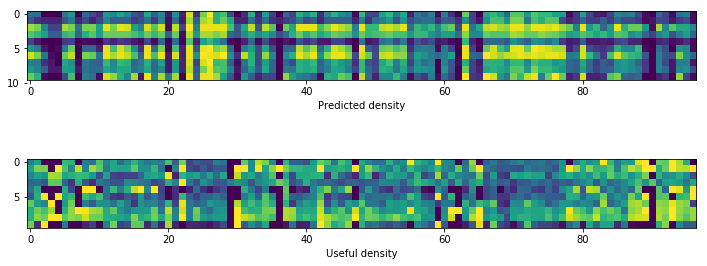

In [26]:
plt.figure(figsize=(12, 5))

density_arr = np.zeros((10, 97))
for idx, data, density in results_data[['index', 'dataset', 'predicted_density_mean']].values:
    density_arr[indices_list.index(idx), datasets_arr.index(data)] = density
plt.subplot(2, 1, 1)
plt.imshow(density_arr)
plt.xlabel('Predicted density')
for idx, data, density in results_data[['index', 'dataset', 'useful_density_mean']].values:
    density_arr[indices_list.index(idx), datasets_arr.index(data)] = density
plt.subplot(2, 1, 2)
plt.imshow(density_arr)
plt.xlabel('Useful density')

Text(0.5,0,'Useful density (sorted by predicted)')

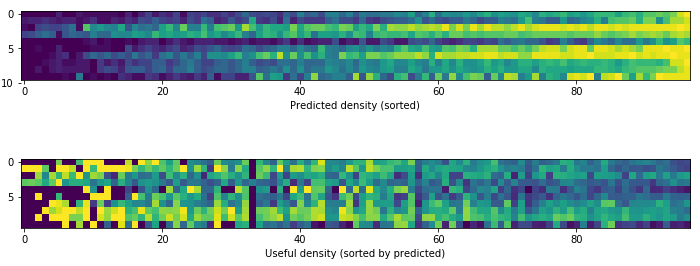

In [27]:
plt.figure(figsize=(12, 5))
for idx, data, density in results_data[['index', 'dataset', 'predicted_density_mean']].values:
    density_arr[indices_list.index(idx), datasets_arr.index(data)] = density
datasets_ordering = np.argsort(density_arr.mean(axis=0))
plt.subplot(2, 1, 1)
plt.imshow(density_arr[:, datasets_ordering])
plt.xlabel('Predicted density (sorted)')
for idx, data, density in results_data[['index', 'dataset', 'useful_density_mean']].values:
    density_arr[indices_list.index(idx), datasets_arr.index(data)] = density
plt.subplot(2, 1, 2)
plt.imshow(density_arr[:, datasets_ordering])
plt.xlabel('Useful density (sorted by predicted)')

In [46]:
results_data = pd.read_csv('results_data.csv', index_col=0)
results_shalamov = None
for i in range(10):
    print('Parsing folder', i + 1)
    results, results_s = parse_results('/tmp/results_shalamov_{}'.format(i+1))
    results_s_c = pd.DataFrame(data=results_s, columns=['index', 'dataset', 'index_value_shalamov_' + str(i+1)])
    results_shalamov = results_s_c if results_shalamov is None else pd.merge(results_shalamov, results_s_c)
results_shalamov

Parsing folder 1
Parsing folder 2
Parsing folder 3
Parsing folder 4
Parsing folder 5
Parsing folder 6
Parsing folder 7
Parsing folder 8
Parsing folder 9
Parsing folder 10


,index,dataset,index_value_shalamov_1,index_value_shalamov_2,index_value_shalamov_3,index_value_shalamov_4,index_value_shalamov_5,index_value_shalamov_6,index_value_shalamov_7,index_value_shalamov_8,index_value_shalamov_9,index_value_shalamov_10
0,calinski_harabaz,Concrete_Data,281.509713,492.925753,376.463330,280.395442,501.278723,501.278723,410.822349,281.369775,300.720549,492.925753
1,calinski_harabaz,HappinessRank_2015,43.485134,30.346388,46.810102,27.908282,52.730853,53.843728,54.836221,33.256477,54.836221,19.432309
2,calinski_harabaz,ICU,115.645732,115.645732,115.645732,67.799772,115.645732,22.113938,72.055017,72.055782,22.113938,115.645732
3,calinski_harabaz,ParkinsonSpeechDataset,227.146568,79.842490,68.246353,252.316914,181.301868,65.130389,40.755346,217.356938,202.129379,252.316914
4,calinski_harabaz,analcatdata_lawsuit,359.585734,263.262528,488.616452,488.216515,263.262528,263.262528,263.262528,488.616452,263.262528,488.616452
5,calinski_harabaz,analcatdata_vineyard,471.360224,464.542454,555.427598,464.542454,560.014337,464.542454,549.956242,475.453759,492.221507,0.000000
6,calinski_harabaz,analcatdata_wildcat,105.261192,106.222572,108.376829,97.811835,113.277636,265.544488,106.222572,101.646701,81.428229,265.544488
7,calinski_harabaz,arsenic_female_bladder,552.749441,954.864834,397.889936,1086.231526,1575.619242,1568.729123,1125.335018,1582.007760,1071.782539,1111.406916
8,calinski_harabaz,arsenic_male_bladder,625.886455,1316.102384,592.314595,1063.443246,1700.182105,1785.954941,1782.256749,1784.758965,1316.102384,1109.058950
9,calinski_harabaz,arsenic_male_lung,950.385423,463.045984,955.659650,1890.964508,1924.836205,528.013086,997.760739,1906.147682,598.977875,1096.395713


In [13]:
index_value_shalamov_mean = np.zeros(len(results_shalamov))
index_value_shalamov_nums = np.zeros(len(results_shalamov), dtype='int')
for i in range(1, 11):
    #column = results_shalamov['index_value_shalamov_' + str(i)]
    #valid = np.where(results_shalamov['index'] != 'davies_bouldin', column >= -1, column < 1e5
    #index_value_shalamov_mean += np.where(valid, column, 0)
    #index_value_shalamov_nums += valid
    index_value_shalamov_mean += results_shalamov['index_value_shalamov_' + str(i)]
#index_value_shalamov_mean /= index_value_shalamov_nums
index_value_shalamov_mean /= 10
#np.unique(index_value_shalamov_nums)

In [18]:
results_shalamov = results_shalamov[index_value_shalamov_nums  > 0]
index_value_shalamov_mean = index_value_shalamov_mean[index_value_shalamov_nums > 0]
len(results_shalamov)

913

In [14]:
results_shalamov['index_value_shalamov_mean'] = index_value_shalamov_mean
index_value_shalamov_std = np.zeros(len(results_shalamov))
index_value_shalamov_nums = np.zeros(len(results_shalamov), dtype='int')
for i in range(1, 11):
    #column = results_shalamov['index_value_shalamov_' + str(i)]
    #valid = column >= -1
    #index_value_shalamov_std += (np.where(valid, (column - index_value_shalamov_mean) ** 2, 0))
    #index_value_shalamov_nums += valid
    index_value_shalamov_std += (column - index_value_shalamov_mean) ** 2
#index_value_shalamov_std = np.sqrt(index_value_shalamov_std / index_value_shalamov_nums)
index_value_shalamov_std = np.sqrt(index_value_shalamov_std / 10)
results_shalamov['index_value_shalamov_std'] = index_value_shalamov_std
results_shalamov.head()

NameError: name 'column' is not defined

In [5]:
results_merged = pd.merge(results_data, results_shalamov)
results_merged

,index,dataset,index_value_predicted_1,time_predicted_1,predicted_density_1,useful_density_1,index_value_all_1,time_all_1,index_value_predicted_2,time_predicted_2,...,index_value_shalamov_3,index_value_shalamov_4,index_value_shalamov_5,index_value_shalamov_6,index_value_shalamov_7,index_value_shalamov_8,index_value_shalamov_9,index_value_shalamov_10,index_value_shalamov_mean,index_value_shalamov_std
0,calinski_harabaz,Concrete_Data,501.278723,13.426349,0.290323,0.444444,476.021936,29.055345,501.268539,5.069461,...,376.463330,280.395442,501.278723,501.278723,410.822349,281.369775,300.720549,492.925753,391.969011,1.009567e+02
1,calinski_harabaz,HappinessRank_2015,48.551073,7.727365,0.419355,0.307692,47.746457,4.969359,50.486460,2.300425,...,46.810102,27.908282,52.730853,53.843728,54.836221,33.256477,54.836221,19.432309,41.748572,2.231626e+01
2,calinski_harabaz,ICU,115.645732,6.799450,0.290323,0.222222,115.645732,5.410862,115.645732,2.818114,...,115.645732,67.799772,115.645732,22.113938,72.055017,72.055782,22.113938,115.645732,83.436710,3.220902e+01
3,calinski_harabaz,ParkinsonSpeechDataset,252.308908,89.796411,0.838710,0.346154,252.316216,118.420187,252.308908,44.400892,...,68.246353,252.316914,181.301868,65.130389,40.755346,217.356938,202.129379,252.316914,158.654316,9.366260e+01
4,calinski_harabaz,analcatdata_lawsuit,488.616452,0.866733,0.161290,0.600000,488.616452,3.955836,488.616452,0.517348,...,488.616452,488.216515,263.262528,263.262528,263.262528,488.616452,263.262528,488.616452,362.996425,1.256200e+02
5,calinski_harabaz,analcatdata_vineyard,487.979972,6.647447,0.322581,0.500000,487.979972,12.216706,507.344012,2.621178,...,555.427598,464.542454,560.014337,464.542454,549.956242,475.453759,492.221507,0.000000,449.806103,1.000000e+09
6,calinski_harabaz,analcatdata_wildcat,74.135943,1.351986,0.096774,1.000000,93.956138,6.700281,81.919294,1.603952,...,108.376829,97.811835,113.277636,265.544488,106.222572,101.646701,81.428229,265.544488,135.133654,1.304108e+02
7,calinski_harabaz,arsenic_female_bladder,1015.220872,11.428143,0.290323,0.555556,930.142797,16.745069,930.142797,3.309756,...,397.889936,1086.231526,1575.619242,1568.729123,1125.335018,1582.007760,1071.782539,1111.406916,1102.661634,8.745283e+00
8,calinski_harabaz,arsenic_male_bladder,477.550096,36.683519,0.290323,0.555556,899.388376,9.770076,477.550096,31.864429,...,592.314595,1063.443246,1700.182105,1785.954941,1782.256749,1784.758965,1316.102384,1109.058950,1307.606077,1.985471e+02
9,calinski_harabaz,arsenic_male_lung,921.095023,34.023737,0.354839,0.636364,921.095023,23.258795,921.095023,22.541647,...,955.659650,1890.964508,1924.836205,528.013086,997.760739,1906.147682,598.977875,1096.395713,1131.218686,3.482297e+01


In [15]:
index_less = (results_merged['index_value_predicted_mean'] + results_merged['index_value_predicted_std'] < results_merged['index_value_shalamov_mean'] - results_merged['index_value_shalamov_std']).astype('bool')
index_greater = (results_merged['index_value_predicted_mean'] - results_merged['index_value_predicted_std'] > results_merged['index_value_shalamov_mean'] + results_merged['index_value_shalamov_std']).astype('bool')
index_losing = np.where(results_shalamov['index'] != 'davies_bouldin', index_less, index_greater).astype('bool')
index_winning = np.where(results_shalamov['index'] != 'davies_bouldin', index_greater, index_less).astype('bool')
index_losing.sum(), len(results_merged) - index_losing.sum() - index_winning.sum(), index_winning.sum()

(120, 587, 263)

In [16]:
for idx in np.unique(results_merged['index']):
    results_merged_idx = results_merged[results_merged['index'] == idx]
    index_less = (results_merged_idx['index_value_predicted_mean'] + results_merged_idx['index_value_predicted_std'] < results_merged_idx['index_value_shalamov_mean'] - results_merged_idx['index_value_shalamov_std']).astype('bool')
    index_greater = (results_merged_idx['index_value_predicted_mean'] - results_merged_idx['index_value_predicted_std'] > results_merged_idx['index_value_shalamov_mean'] + results_merged_idx['index_value_shalamov_std']).astype('bool')
    index_losing = index_less if idx != 'davies_bouldin' else index_greater
    index_winning = index_less if idx == 'davies_bouldin' else index_greater
    print(idx, index_losing.sum(), (~(index_losing | index_winning)).sum(), index_winning.sum())

calinski_harabaz 11 50 36
davies_bouldin 5 54 38
dunn 5 57 35
dvcb 4 22 71
generalized_dunn_13 25 63 9
generalized_dunn_41 4 76 17
generalized_dunn_43 28 64 5
generalized_dunn_51 4 65 28
generalized_dunn_53 22 64 11
silhouette 12 72 13


In [12]:
results_data = pd.read_csv('results_data.csv', index_col=0)
results_shalamov = pd.read_csv('results_shalamov_unfiltered.csv', index_col=0)